In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt

pd.options.display.max_rows = 1000

data = pd.read_csv(r'dataset/covid19_europe.csv')
# data.head() # show only first rows
display(data)

,ObservationDate,Country_Region,Province_State,Confirmed,Deaths,Recovered,Active
0,2020-01-24,France,NaN,2,0,0,0.0
1,2020-01-25,France,NaN,3,0,0,0.0
2,2020-01-26,France,NaN,3,0,0,0.0
3,2020-01-27,France,NaN,3,0,0,0.0
4,2020-01-28,France,NaN,4,0,0,0.0
...,...,...,...,...,...,...,...
63887,2020-12-31,United Kingdom,Northern Ireland,72834,1322,0,71512.0
63888,2020-12-31,United Kingdom,Scotland,127453,4578,0,122875.0
63889,2020-12-31,United Kingdom,Turks and Caicos Islands,893,6,783,104.0
63890,2020-12-31,United Kingdom,Unknown,0,0,0,0.0


# ETL

In [4]:
# check null values
data.isnull().sum()

ObservationDate        0
Country_Region         0
Province_State     11821
Confirmed              0
Deaths                 0
Recovered              0
Active                24
dtype: int64

In [2]:
# drop province state due to too much null values
# drop Active because not clear the meaning of this attribute and how they calculated it
data = data.drop(['Province_State', 'Active'], axis=1)
display(data)

,ObservationDate,Country_Region,Confirmed,Deaths,Recovered
0,2020-01-24,France,2,0,0
1,2020-01-25,France,3,0,0
2,2020-01-26,France,3,0,0
3,2020-01-27,France,3,0,0
4,2020-01-28,France,4,0,0
...,...,...,...,...,...
63887,2020-12-31,United Kingdom,72834,1322,0
63888,2020-12-31,United Kingdom,127453,4578,0
63889,2020-12-31,United Kingdom,893,6,783
63890,2020-12-31,United Kingdom,0,0,0


In [12]:
# check types of data
print(data.dtypes)

# check values for Country Region
print("unique values for Country Region: ", data["Country_Region"].unique())

ObservationDate    object
Country_Region     object
Confirmed           int64
Deaths              int64
Recovered           int64
dtype: object
unique values for Country Region:  ['France' 'Germany' 'Finland' 'Italy' 'United Kingdom' 'Russia' 'Sweden'
 'Spain' 'Belgium' 'Austria' 'Croatia' 'Switzerland' 'Greece'
 'North Macedonia' 'Norway' 'Romania' 'Denmark' 'Estonia' 'Netherlands'
 'San Marino' 'Belarus' 'Iceland' 'Lithuania' 'Ireland' 'Luxembourg'
 'Monaco' 'Czechia' 'Portugal' 'Andorra' 'Latvia' 'Ukraine' 'Hungary'
 'Liechtenstein' 'Poland' 'Bosnia and Herzegovina' 'Slovenia' 'Serbia'
 'Slovakia' 'Vatican City' 'Malta' 'Bulgaria' 'Moldova' 'Albania'
 'Holy See' 'Guernsey' 'Jersey' 'Montenegro']


In [3]:
# transform date in date format
from datetime import datetime

def change_date(date_str):
    date_object = datetime.strptime(date_str, '%Y-%m-%d').date()
    return date_object


data['ObservationDate'] = data['ObservationDate'].apply(change_date)



In [16]:
display(data)

,ObservationDate,Country_Region,Confirmed,Deaths,Recovered
0,2020-01-24,France,2,0,0
1,2020-01-25,France,3,0,0
2,2020-01-26,France,3,0,0
3,2020-01-27,France,3,0,0
4,2020-01-28,France,4,0,0
...,...,...,...,...,...
63887,2020-12-31,United Kingdom,72834,1322,0
63888,2020-12-31,United Kingdom,127453,4578,0
63889,2020-12-31,United Kingdom,893,6,783
63890,2020-12-31,United Kingdom,0,0,0


In [4]:
# check types of data
print(data.dtypes)

i = 0
for row in data.iterrows():
    print(row[1][0].year) # .year, .month, .day OK!!
    i = i + 1
    if(i == 2):
        break

ObservationDate    object
Country_Region     object
Confirmed           int64
Deaths              int64
Recovered           int64
dtype: object
2020
2020


### Understand meaning of cumulative!

<AxesSubplot:>

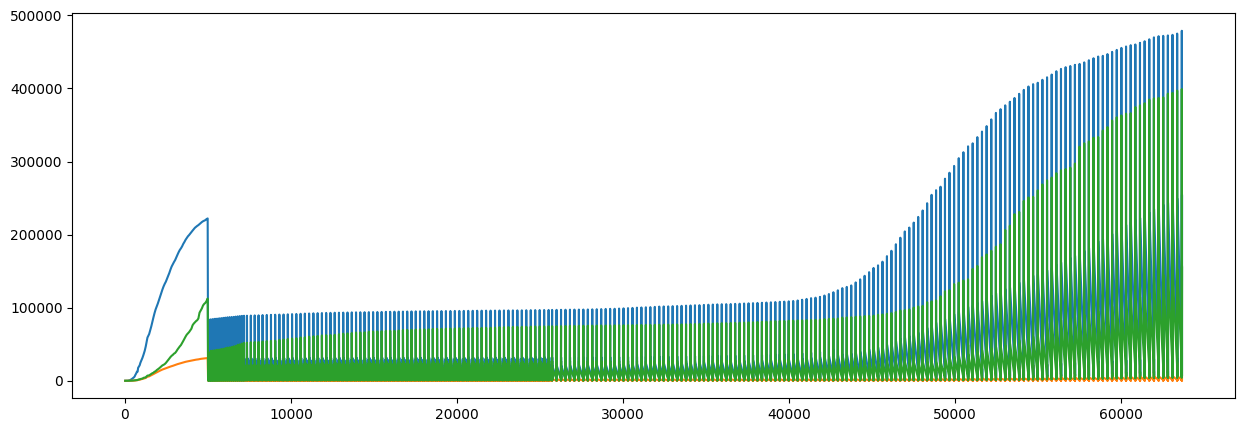

In [35]:
# example italian data to understand if cumulative values -> each day a registration of new cases! 
# maybe high value when pandemy started, then less values beacause of lockdown and then because of summer and high temperature. 

italian_data = data[data['Country_Region']=='Italy']
endog = italian_data['Confirmed']
endog.plot(figsize=(15, 5))

endog = italian_data['Deaths']
endog.plot(figsize=(15, 5))

endog = italian_data['Recovered']
endog.plot(figsize=(15, 5))



In [40]:
"""  
# there are rows with same date and same country -> we need to agreggate values per days for each country
# -> sum values where same date and same country

new_data = data.groupby(['ObservationDate', 'Country_Region'])[['Confirmed','Recovered','Deaths']].agg(np.sum)  

print(new_data)

"""

                                Confirmed  Recovered  Deaths
ObservationDate Country_Region                              
2020-01-24      France                  2          0       0
2020-01-25      France                  3          0       0
2020-01-26      France                  3          0       0
2020-01-27      France                  3          0       0
2020-01-28      France                  4          0       0
...                                   ...        ...     ...
2020-12-31      Spain             1928265     150376   50837
                Sweden             437379          0    8727
                Switzerland        452296     317600    7645
                Ukraine           1086997     736611   19281
                United Kingdom    2496231       5479   73622

[13155 rows x 3 columns]


# DESCRIPTIVE ANALYSIS

In [6]:
# pie chart to visualize total cases for each country
# to see what countries have many cases
countries = data.groupby(['Country_Region'])[['Confirmed','Recovered','Deaths']].agg(np.sum) 
print(countries)

# countries['Confirmed'].plot.pie(autopct="%.1f%%"); # covid cases for country 

                        Confirmed  Recovered    Deaths
Country_Region                                        
Albania                   3693101    1980336     87375
Andorra                    678294     550059     15333
Austria                  22043509   17605096    354165
Belarus                  20205227   16917033    170349
Belgium                  53510585    3741443   2901163
Bosnia and Herzegovina    7978911    4987647    248683
Bulgaria                 11041180    5079987    345633
Croatia                   9881857    8250046    156199
Czechia                  40817981   29962980    599382
Denmark                   9246883    7128901    174973
Estonia                   1349513     901295     20641
Finland                   3195482    2390122     87901
France                  206540911   26113135   9180615
Germany                 116536543   88516760   2908776
Greece                    7935889    2252712    207554
Guernsey                        3          0         0
Holy See  

In [7]:
countries_ord = countries.sort_values(by='Confirmed', ascending=False)
print(countries_ord)



                        Confirmed  Recovered    Deaths
Country_Region                                        
Russia                  290892122  217823031   4896592
France                  206540911   26113135   9180615
Spain                   184838037   38336466   8629653
United Kingdom          173138558     542154  11585237
Italy                   150428536   86295688  10475292
Germany                 116536543   88516760   2908776
Poland                   69551972   43857241   1415627
Ukraine                  66416313   34114430   1230047
Belgium                  53510585    3741443   2901163
Netherlands              51121584     709085   1806831
Romania                  41509828   30475931   1235731
Czechia                  40817981   29962980    599382
Sweden                   29738578     160063   1420257
Switzerland              28849607   20548383    700149
Portugal                 28332442   19151887    609705
Austria                  22043509   17605096    354165
Belarus   

In [8]:
confirmed = countries_ord.drop(['Deaths', 'Recovered'], axis=1)
print(confirmed)

                        Confirmed
Country_Region                   
Russia                  290892122
France                  206540911
Spain                   184838037
United Kingdom          173138558
Italy                   150428536
Germany                 116536543
Poland                   69551972
Ukraine                  66416313
Belgium                  53510585
Netherlands              51121584
Romania                  41509828
Czechia                  40817981
Sweden                   29738578
Switzerland              28849607
Portugal                 28332442
Austria                  22043509
Belarus                  20205227
Serbia                   15797555
Hungary                  15516561
Moldova                  12152607
Bulgaria                 11041180
Ireland                  10369122
Croatia                   9881857
Denmark                   9246883
Slovakia                  8268717
Bosnia and Herzegovina    7978911
Greece                    7935889
North Macedoni

In [9]:
first_n = 8
last_n = len(confirmed.index) - first_n

confirmed_new = confirmed.head(first_n)
print(confirmed_new)

# print(confirmed.tail(last_n))

other_values = confirmed.tail(last_n).sum()

# confirmed.tail(last_n).groupby(['Country_Region'])[['Confirmed']].agg(np.sum)
print('######## other values ########')
print(other_values)
print(other_values.index)
print('value:', other_values.Confirmed)


confirmed_new = pd.DataFrame(confirmed_new)
print('####### DATAFRAME WITH FIRST N COUNTRY IN ORDER #########')
print(confirmed_new)
print(confirmed_new.shape)


d = {'Confirmed': other_values.Confirmed}
ser = pd.Series(data=d, index=['Confirmed'])
print('### SERIES ###')
print(ser)
ser.name = 'Others'
print(ser.name)

# append series to confirmed_new
confirmed_new = confirmed_new.append(ser)
print(confirmed_new)

"""  

d = {other_values}
ser = pd.Series(data=d)
print('### SERIES ###')
print(ser)


confirmed_new = confirmed_new.append({'Confirmed':other_values})
print('################')
print(confirmed_new)
print(confirmed_new.shape)




# add row "others" to dataframe
new_row = pd.DataFrame({'Confirmed':other_values, 'Country_Region':'others'})
df = confirmed_new.append(pd.DataFrame([new_row])) # substitute df with confirmed_new

print(df)

"""






                Confirmed
Country_Region           
Russia          290892122
France          206540911
Spain           184838037
United Kingdom  173138558
Italy           150428536
Germany         116536543
Poland           69551972
Ukraine          66416313
######## other values ########
Confirmed    463898428
dtype: int64
Index(['Confirmed'], dtype='object')
value: 463898428
####### DATAFRAME WITH FIRST N COUNTRY IN ORDER #########
                Confirmed
Country_Region           
Russia          290892122
France          206540911
Spain           184838037
United Kingdom  173138558
Italy           150428536
Germany         116536543
Poland           69551972
Ukraine          66416313
(8, 1)
### SERIES ###
Confirmed    463898428
dtype: int64
Others
                Confirmed
Country_Region           
Russia          290892122
France          206540911
Spain           184838037
United Kingdom  173138558
Italy           150428536
Germany         116536543
Poland           69551972
Uk

/var/folders/k8/b6lhrl0x45g7kg3gtvt0n1240000gn/T/ipykernel_74007/366780214.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confirmed_new = confirmed_new.append(ser)


'  \n\nd = {other_values}\nser = pd.Series(data=d)\nprint(\'### SERIES ###\')\nprint(ser)\n\n\nconfirmed_new = confirmed_new.append({\'Confirmed\':other_values})\nprint(\'################\')\nprint(confirmed_new)\nprint(confirmed_new.shape)\n\n\n\n\n# add row "others" to dataframe\nnew_row = pd.DataFrame({\'Confirmed\':other_values, \'Country_Region\':\'others\'})\ndf = confirmed_new.append(pd.DataFrame([new_row])) # substitute df with confirmed_new\n\nprint(df)\n\n'

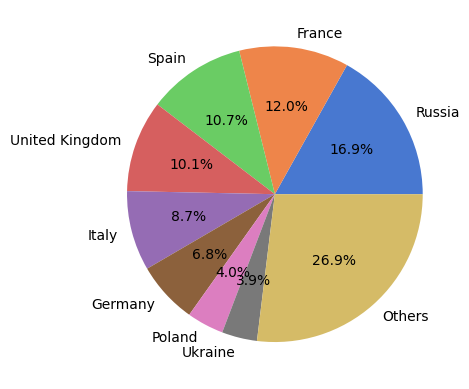

" \n# number of records for region???\nimport seaborn as sns\n\nsns.histplot(data=countries_ord, y=countries_ord['Confirmed'])\n# check if country repeated in the same day, ex: -> if aggr per day NO PROBLEM (filter on Italy and then aggregate)\n# 11/05 italy  2\n# 11/05 italy  5\n\n"

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('muted')[0:15]

plt.pie(confirmed_new['Confirmed'], labels=confirmed_new.index, colors = colors, autopct="%.1f%%")
plt.show()

""" 
# number of records for region???
import seaborn as sns

sns.histplot(data=countries_ord, y=countries_ord['Confirmed'])
# check if country repeated in the same day, ex: -> if aggr per day NO PROBLEM (filter on Italy and then aggregate)
# 11/05 italy  2
# 11/05 italy  5

"""

                 Confirmed  Recovered  Deaths
ObservationDate                              
2020-01-24               2          0       0
2020-01-25               3          0       0
2020-01-26               3          0       0
2020-01-27               3          0       0
2020-01-28               8          0       0
2020-01-29              10          0       0
2020-01-30              10          0       0
2020-01-31              63          0       0
2020-02-01              95          0       0
2020-02-02              10          0       0
2020-02-03              48          0       0
2020-02-04              13          0       0
2020-02-07              77          0       0
2020-02-08              44          0       0
2020-02-09              40          0       0
2020-02-10              16          0       0
2020-02-11              32          0       0
2020-02-12             121         62       0
2020-02-13              80          5       0
2020-02-15             140        

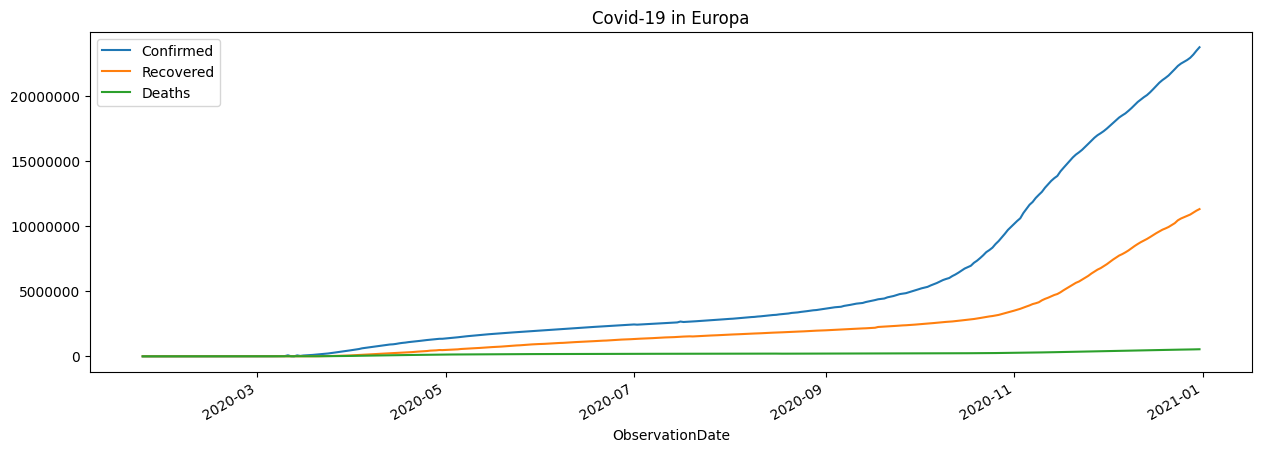

In [11]:
import matplotlib.pyplot as plt
# plot times series for covid cases, covid recoverings, covid deaths in Europe -> aggreagate per days values
europe = data.groupby(['ObservationDate'])[['Confirmed','Recovered','Deaths']].agg(np.sum) 
europe.index = pd.to_datetime(europe.index)
print(europe)

'''  
# check if index is temporal -> YES! In this way we have the date as index and it's a datetime format because we previously cast this attribute!
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Days')
ax.set_ylabel('Covid Cases')
plt.plot(europe.index, europe['Confirmed'])
plt.show()

'''

eur_conf = europe['Confirmed']
eur_conf.plot(figsize=(15, 5))

eur_rec = europe['Recovered']
eur_rec.plot(figsize=(15, 5))

eur_death = europe['Deaths']
eur_death.plot(figsize=(15, 5))

plt.ticklabel_format(axis='y', style='plain') # 
plt.title("Covid-19 in Europa")
plt.legend()


      ObservationDate Country_Region  Confirmed  Deaths  Recovered
14         2020-01-31          Italy          2       0          0
19         2020-01-31          Italy          2       0          0
22         2020-01-31          Italy          2       0          0
25         2020-01-31          Italy          2       0          0
28         2020-01-31          Italy          2       0          0
...               ...            ...        ...     ...        ...
63686      2020-12-31          Italy      93644    2412      57364
63687      2020-12-31          Italy     120328    3673     106977
63688      2020-12-31          Italy      28960     624      24559
63689      2020-12-31          Italy       7273     379       6483
63690      2020-12-31          Italy     253875    6539     156263

[4913 rows x 5 columns]
                 Confirmed  Recovered  Deaths
ObservationDate                              
2020-01-31              14          0       0
2020-02-07              42       

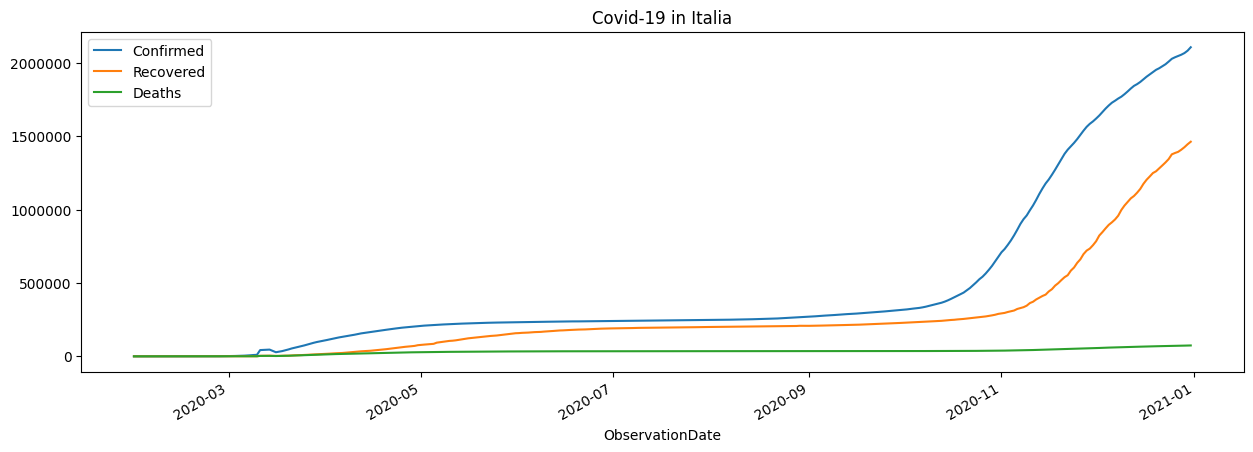

In [12]:
# plot times series for covid cases, covid recoverings, covid deaths in Italy -> aggreagate per days values
italian_data = data[data['Country_Region']=='Italy']
print(italian_data)

italian_data = italian_data.groupby(['ObservationDate'])[['Confirmed','Recovered','Deaths']].agg(np.sum) 
italian_data.index = pd.to_datetime(italian_data.index)
print(italian_data)


# italian_data = data[data['Country_Region']=='Italy']
it_conf = italian_data['Confirmed']
it_conf.plot(figsize=(15, 5))

it_rec = italian_data['Recovered']
it_rec.plot(figsize=(15, 5))

it_death = italian_data['Deaths']
it_death.plot(figsize=(15, 5))

plt.ticklabel_format(axis='y', style='plain') # 
plt.title("Covid-19 in Italia")
plt.legend()



Some consideration about italian data: not to high in spring thanks to lockdown?
not too high in summer thanks to low temperatures?
many cases again in winter due to low temperature and meeting in close places?
Trend only? Seasonality only? it seems only trend, but if we had even 2021 we probably could say only seasonality with more cases in winter and less in summer. There could be even hexogeous variables like vaccins in future years, or lockdown in 2020 spring. But how to consider them?

([<matplotlib.axis.XTick at 0x1386c2d60>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

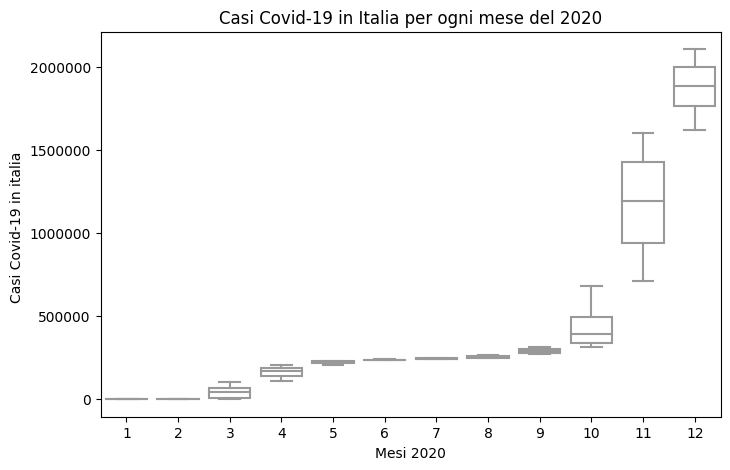

In [170]:
# plot outliers for covid cases Italy by month

data_boxplot = []
for month in range(1, 13): # from january to december
    data_boxplot.append(italian_data.loc[(italian_data.index.month == month)]['Confirmed'])
    
import seaborn as sns
plt.figure(figsize=(8,5))
ax = plt.gca()
sns.boxplot(data=data_boxplot, color='w', whis=1.5)
ax.set_xlabel('Mesi 2020')
ax.set_ylabel('Casi Covid-19 in italia ')
plt.ticklabel_format(axis='y', style='plain') 
plt.title("Casi Covid-19 in Italia per ogni mese del 2020")
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)





Some considerations: month more variable is october, where registered values of covid cases are more variable day by day
Obviosly, the trend of boxplot during the year corrisponds to thre trend of time series just showed

# Forecasting

Focus on prediction of covid-19 cases (not recoverings and deaths) in Italy

### Decomposition of italian covid cases to understand trend and seasonality

In [188]:
print(it_conf)

ObservationDate
2020-01-31         14
2020-02-07         42
2020-02-21         20
2020-02-22         62
2020-02-23        155
2020-02-24        229
2020-02-25        322
2020-02-26        453
2020-02-27        655
2020-02-28        888
2020-02-29       1128
2020-03-01       1694
2020-03-02       2036
2020-03-03       2502
2020-03-04       3089
2020-03-05       3858
2020-03-06       4636
2020-03-07       5883
2020-03-08       7375
2020-03-09       9172
2020-03-10      10149
2020-03-11      42584
2020-03-14      45904
2020-03-16      27980
2020-03-17      31506
2020-03-18      35713
2020-03-19      41035
2020-03-20      47021
2020-03-21      53578
2020-03-22      59138
2020-03-23      63927
2020-03-24      69176
2020-03-25      74386
2020-03-26      80589
2020-03-27      86498
2020-03-28      92472
2020-03-29      97689
2020-03-30     101739
2020-03-31     105792
2020-04-01     110574
2020-04-02     115242
2020-04-03     119827
2020-04-04     124632
2020-04-05     128948
2020-04-06     1

ObservationDate
2020-01-31         14.0
2020-02-01         14.0
2020-02-02         14.0
2020-02-03         14.0
2020-02-04         14.0
2020-02-05         14.0
2020-02-06         14.0
2020-02-07         42.0
2020-02-08         42.0
2020-02-09         42.0
2020-02-10         42.0
2020-02-11         42.0
2020-02-12         42.0
2020-02-13         42.0
2020-02-14         42.0
2020-02-15         42.0
2020-02-16         42.0
2020-02-17         42.0
2020-02-18         42.0
2020-02-19         42.0
2020-02-20         42.0
2020-02-21         20.0
2020-02-22         62.0
2020-02-23        155.0
2020-02-24        229.0
2020-02-25        322.0
2020-02-26        453.0
2020-02-27        655.0
2020-02-28        888.0
2020-02-29       1128.0
2020-03-01       1694.0
2020-03-02       2036.0
2020-03-03       2502.0
2020-03-04       3089.0
2020-03-05       3858.0
2020-03-06       4636.0
2020-03-07       5883.0
2020-03-08       7375.0
2020-03-09       9172.0
2020-03-10      10149.0
2020-03-11      42584.0


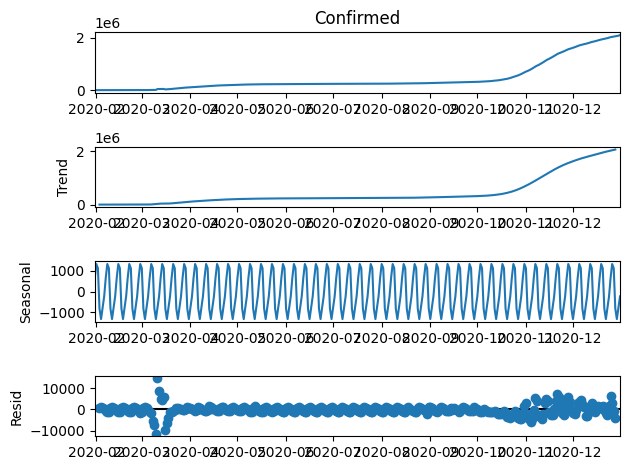

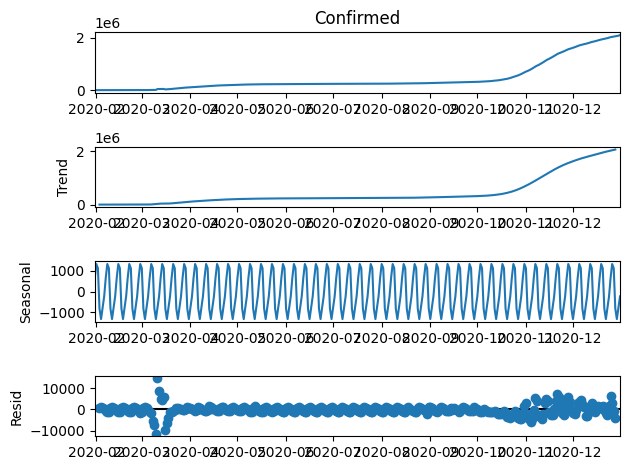

In [13]:
from datetime import date, timedelta
import pandas as pd
import statsmodels.api as sm

# put all days for italian cases -> with 0 if additive and 1 if multiplicative
# print(italian_data)

italian_data = data[data['Country_Region']=='Italy']
italian_data = italian_data.drop(['Deaths', 'Recovered', 'Country_Region'], axis=1)
italian_data['ObservationDate'] = pd.to_datetime(italian_data['ObservationDate'])
# print(italian_data)


#Start date and end_date
start_date = pd.to_datetime("2020-01-31")
end_date = pd.to_datetime("2020-12-31") 

#List of all dates
all_date = pd.date_range(start_date, end_date, freq='d')

#Left join your main data on dates data
all_date_df = pd.DataFrame({'ObservationDate':all_date})

# print(all_date_df)
tdf = italian_data.groupby('ObservationDate', as_index=False)['Confirmed'].sum()
# print(tdf)


tdf = pd.merge(all_date_df, tdf, on='ObservationDate', how="left")
# tdf.fillna(0, inplace=True)
tdf.fillna(method='ffill', inplace=True)


# print(all_date_df)
# print(tdf) # tdf containes covid cases in italy each day -> in days with no report we put value "0"

tdf = tdf.groupby('ObservationDate')['Confirmed'].sum()
print(tdf)

decomposition = sm.tsa.seasonal_decompose(tdf, model='additive')
decomposition.plot()

# PROBLEM -> we have gaps in date, because values are not reported every day. 
# what can we do? -> aggregate for weeks????


### Multiplicative decomposition

ObservationDate
2020-01-31         14.0
2020-02-01         14.0
2020-02-02         14.0
2020-02-03         14.0
2020-02-04         14.0
2020-02-05         14.0
2020-02-06         14.0
2020-02-07         42.0
2020-02-08         42.0
2020-02-09         42.0
2020-02-10         42.0
2020-02-11         42.0
2020-02-12         42.0
2020-02-13         42.0
2020-02-14         42.0
2020-02-15         42.0
2020-02-16         42.0
2020-02-17         42.0
2020-02-18         42.0
2020-02-19         42.0
2020-02-20         42.0
2020-02-21         20.0
2020-02-22         62.0
2020-02-23        155.0
2020-02-24        229.0
2020-02-25        322.0
2020-02-26        453.0
2020-02-27        655.0
2020-02-28        888.0
2020-02-29       1128.0
2020-03-01       1694.0
2020-03-02       2036.0
2020-03-03       2502.0
2020-03-04       3089.0
2020-03-05       3858.0
2020-03-06       4636.0
2020-03-07       5883.0
2020-03-08       7375.0
2020-03-09       9172.0
2020-03-10      10149.0
2020-03-11      42584.0


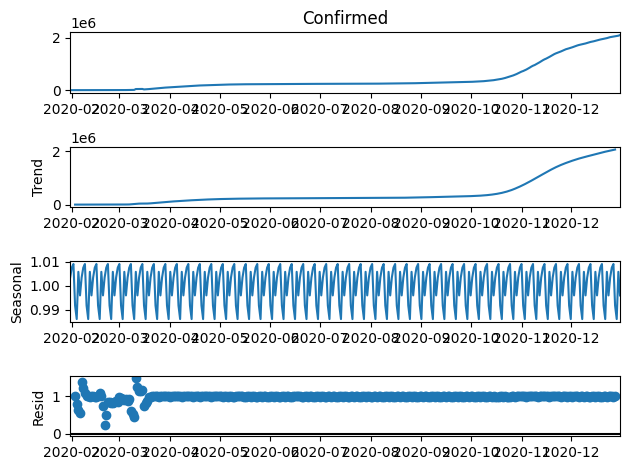

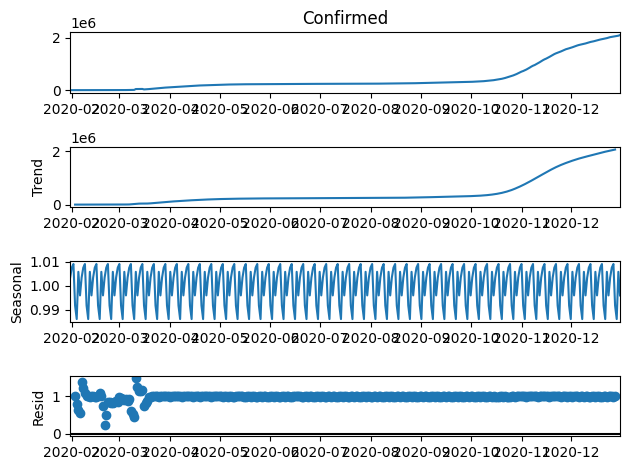

In [14]:
from datetime import date, timedelta
import pandas as pd
import statsmodels.api as sm

# put all days for italian cases -> with 0 if additive and 1 if multiplicative
# print(italian_data)

italian_data = data[data['Country_Region']=='Italy']
italian_data = italian_data.drop(['Deaths', 'Recovered', 'Country_Region'], axis=1)
italian_data['ObservationDate'] = pd.to_datetime(italian_data['ObservationDate'])
# print(italian_data)

# it_conf = italian_data['Confirmed']
# it_conf.index = pd.to_datetime(it_conf.index)
# print(it_conf)

#Start date and end_date
start_date = pd.to_datetime("2020-01-31")
end_date = pd.to_datetime("2020-12-31") 

#List of all dates
all_date = pd.date_range(start_date, end_date, freq='d')

#Left join your main data on dates data
all_date_df = pd.DataFrame({'ObservationDate':all_date})

# print(all_date_df)
tdf = italian_data.groupby('ObservationDate', as_index=False)['Confirmed'].sum()
# print(tdf)


tdf = pd.merge(all_date_df, tdf, on='ObservationDate', how="left")
# tdf.fillna(1, inplace=True)
tdf.fillna(method='ffill', inplace=True)

# print(all_date_df)
# print(tdf) # tdf containes covid cases in italy each day -> in days with no report we put value "0"

tdf = tdf.groupby('ObservationDate')['Confirmed'].sum()
print(tdf)


decomposition = sm.tsa.seasonal_decompose(tdf, model='multiplicative')
decomposition.plot()

# PROBLEM -> we have gaps in date, because values are not reported every day. 
# what can we do? -> aggregate for weeks????


### Weekly data and additive decomposition

ObservationDate
2020-01-31         14.0
2020-02-01         14.0
2020-02-02         14.0
2020-02-03         14.0
2020-02-04         14.0
2020-02-05         14.0
2020-02-06         14.0
2020-02-07         42.0
2020-02-08         42.0
2020-02-09         42.0
2020-02-10         42.0
2020-02-11         42.0
2020-02-12         42.0
2020-02-13         42.0
2020-02-14         42.0
2020-02-15         42.0
2020-02-16         42.0
2020-02-17         42.0
2020-02-18         42.0
2020-02-19         42.0
2020-02-20         42.0
2020-02-21         20.0
2020-02-22         62.0
2020-02-23        155.0
2020-02-24        229.0
2020-02-25        322.0
2020-02-26        453.0
2020-02-27        655.0
2020-02-28        888.0
2020-02-29       1128.0
2020-03-01       1694.0
2020-03-02       2036.0
2020-03-03       2502.0
2020-03-04       3089.0
2020-03-05       3858.0
2020-03-06       4636.0
2020-03-07       5883.0
2020-03-08       7375.0
2020-03-09       9172.0
2020-03-10      10149.0
2020-03-11      42584.0


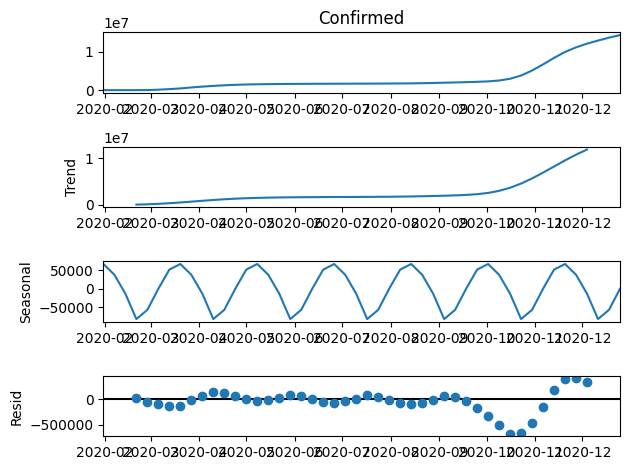

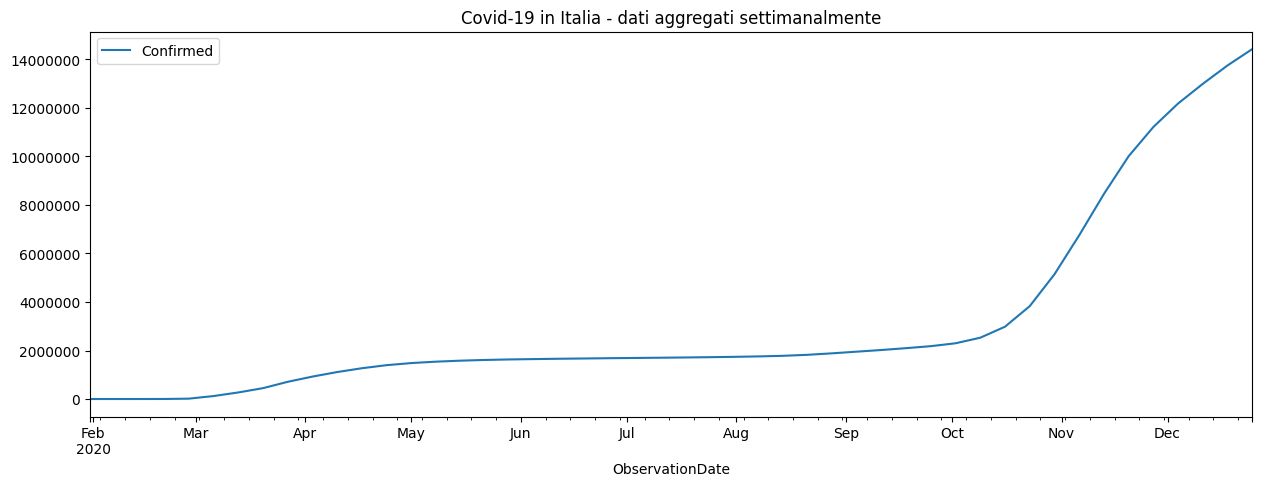

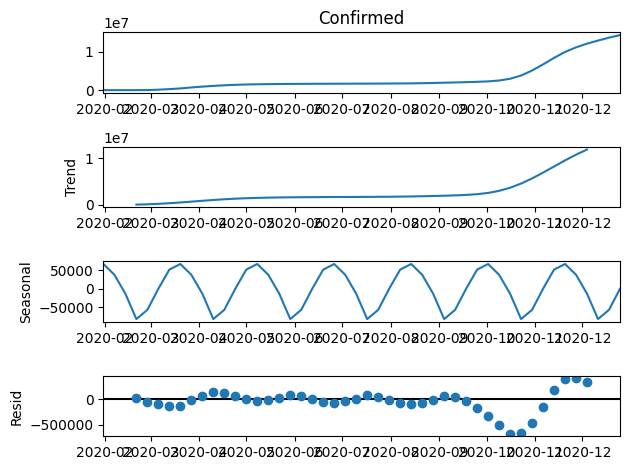

In [224]:
# aggregate italian data for weeks to understand better residuals 


# put all days for italian cases -> with 0 if additive and 1 if multiplicative

italian_data = data[data['Country_Region']=='Italy']
italian_data = italian_data.drop(['Deaths', 'Recovered', 'Country_Region'], axis=1)
italian_data['ObservationDate'] = pd.to_datetime(italian_data['ObservationDate'])
# print(italian_data)

# insert date in gaps with covid values = 0

#Start date and end_date
start_date = pd.to_datetime("2020-01-31")
end_date = pd.to_datetime("2020-12-31") 

#List of all dates
all_date = pd.date_range(start_date, end_date, freq='d')

#Left join your main data on dates data
all_date_df = pd.DataFrame({'ObservationDate':all_date})

# print(all_date_df)
tdf = italian_data.groupby('ObservationDate', as_index=False)['Confirmed'].sum()
# print(tdf)


tdf = pd.merge(all_date_df, tdf, on='ObservationDate', how="left")
tdf.fillna(method="ffill", inplace=True)
# print(all_date_df)
# print(tdf) # tdf containes covid cases in italy each day -> in days with no report we put value "0"

tdf = tdf.groupby('ObservationDate')['Confirmed'].sum()
# print(tdf) # tdf is italian data fill qith 0 in gaps days

# set date as index with format datetime
tdf.index = pd.to_datetime(tdf.index)
print(tdf)

# resample 7D
weekly_group = tdf.resample('7D')

weekly_tdf = weekly_group.agg(sum)
print(weekly_tdf)

# print time serie with weekly data
weekly_tdf.plot(figsize=(15, 5))

plt.ticklabel_format(axis='y', style='plain') # 
plt.title("Covid-19 in Italia - dati aggregati settimanalmente")
plt.legend()

# do decomposition
# try to solve problem about period
# weekly_tdf = weekly_tdf.asfreq('W').dropna()

decomposition = sm.tsa.seasonal_decompose(weekly_tdf, model='additive', period=7)
decomposition.plot()


### Weekly data and multiplicative decomposition

ObservationDate
2020-01-31         14.0
2020-02-01         14.0
2020-02-02         14.0
2020-02-03         14.0
2020-02-04         14.0
2020-02-05         14.0
2020-02-06         14.0
2020-02-07         42.0
2020-02-08         42.0
2020-02-09         42.0
2020-02-10         42.0
2020-02-11         42.0
2020-02-12         42.0
2020-02-13         42.0
2020-02-14         42.0
2020-02-15         42.0
2020-02-16         42.0
2020-02-17         42.0
2020-02-18         42.0
2020-02-19         42.0
2020-02-20         42.0
2020-02-21         20.0
2020-02-22         62.0
2020-02-23        155.0
2020-02-24        229.0
2020-02-25        322.0
2020-02-26        453.0
2020-02-27        655.0
2020-02-28        888.0
2020-02-29       1128.0
2020-03-01       1694.0
2020-03-02       2036.0
2020-03-03       2502.0
2020-03-04       3089.0
2020-03-05       3858.0
2020-03-06       4636.0
2020-03-07       5883.0
2020-03-08       7375.0
2020-03-09       9172.0
2020-03-10      10149.0
2020-03-11      42584.0


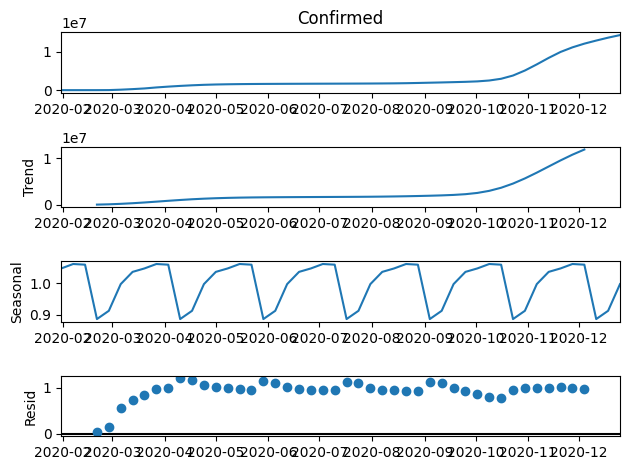

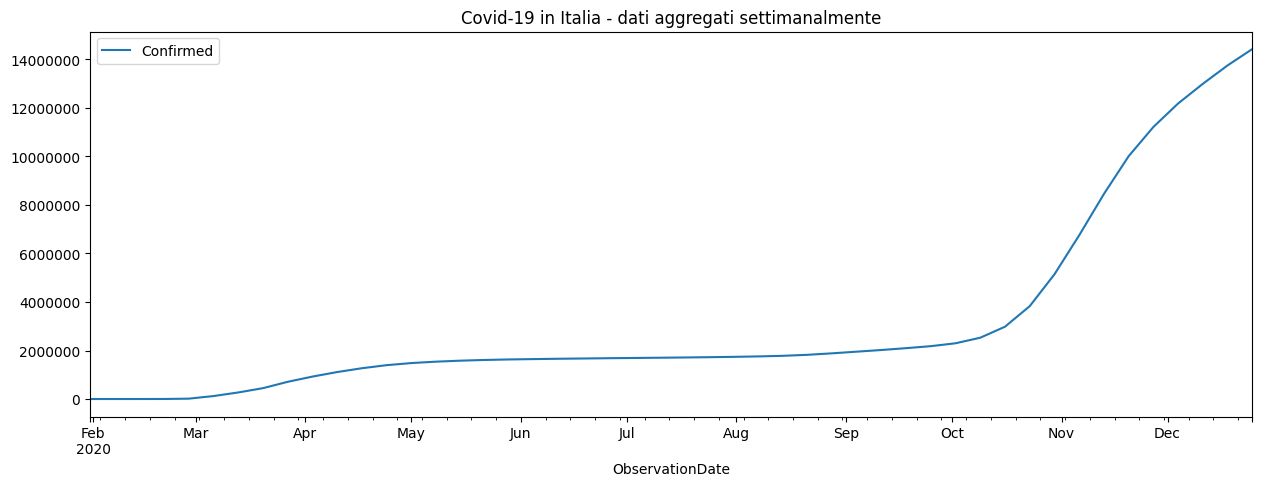

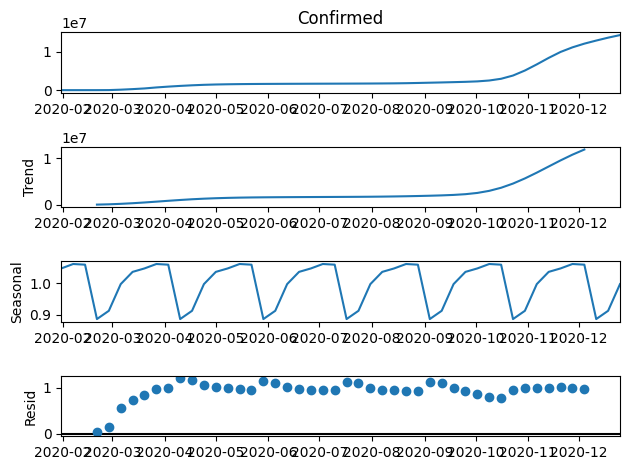

In [225]:
# aggregate italian data for weeks to understand better residuals 


# put all days for italian cases -> with 0 if additive and 1 if multiplicative

italian_data = data[data['Country_Region']=='Italy']
italian_data = italian_data.drop(['Deaths', 'Recovered', 'Country_Region'], axis=1)
italian_data['ObservationDate'] = pd.to_datetime(italian_data['ObservationDate'])
# print(italian_data)

# insert date in gaps with covid values = 0

#Start date and end_date
start_date = pd.to_datetime("2020-01-31")
end_date = pd.to_datetime("2020-12-31") 

#List of all dates
all_date = pd.date_range(start_date, end_date, freq='d')

#Left join your main data on dates data
all_date_df = pd.DataFrame({'ObservationDate':all_date})

# print(all_date_df)
tdf = italian_data.groupby('ObservationDate', as_index=False)['Confirmed'].sum()
# print(tdf)


tdf = pd.merge(all_date_df, tdf, on='ObservationDate', how="left")
tdf.fillna(method="ffill", inplace=True)
# print(all_date_df)
# print(tdf) # tdf containes covid cases in italy each day -> in days with no report we put value "0"

tdf = tdf.groupby('ObservationDate')['Confirmed'].sum()
# print(tdf) # tdf is italian data fill qith 0 in gaps days

# set date as index with format datetime
tdf.index = pd.to_datetime(tdf.index)
print(tdf)

# resample 7D
weekly_group = tdf.resample('7D')

weekly_tdf = weekly_group.agg(sum)
print(weekly_tdf)

# print time serie with weekly data
weekly_tdf.plot(figsize=(15, 5))

plt.ticklabel_format(axis='y', style='plain') # 
plt.title("Covid-19 in Italia - dati aggregati settimanalmente")
plt.legend()

# do decomposition
# try to solve problem about period
# weekly_tdf = weekly_tdf.asfreq('W').dropna()

decomposition = sm.tsa.seasonal_decompose(weekly_tdf, model='multiplicative', period=7)
decomposition.plot()


# Check if time serie is autocorrelate before do prediction

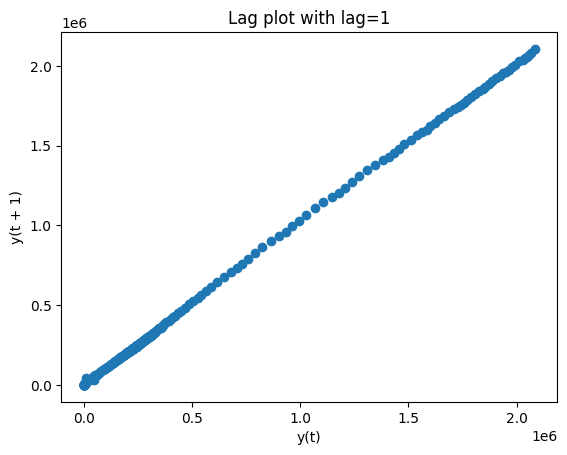

In [252]:
# Check if time serie is autocorrelate before do prediction

# Draw a lag plot
pd.plotting.lag_plot(tdf, lag=1);
plt.title("Lag plot with lag=1");
plt.show(block=True);


## Evaluate if time series is stationary
Considering covid cases in Italy without weekly aggregation, but with previous values in gaps for days

In [15]:
italian_data = data[data['Country_Region']=='Italy']
italian_data = italian_data.drop(['Deaths', 'Recovered', 'Country_Region'], axis=1)
italian_data['ObservationDate'] = pd.to_datetime(italian_data['ObservationDate'])

#Start date and end_date
start_date = pd.to_datetime("2020-01-31")
end_date = pd.to_datetime("2020-12-31") 

#List of all dates
all_date = pd.date_range(start_date, end_date, freq='d')

#Left join your main data on dates data
all_date_df = pd.DataFrame({'ObservationDate':all_date})

# print(all_date_df)
tdf = italian_data.groupby('ObservationDate', as_index=False)['Confirmed'].sum()
# print(tdf)

tdf = pd.merge(all_date_df, tdf, on='ObservationDate', how="left")
tdf.fillna(method="ffill", inplace=True)
tdf = tdf.groupby('ObservationDate')['Confirmed'].sum()

# set date as index with format datetime
tdf.index = pd.to_datetime(tdf.index)
print(tdf)


ObservationDate
2020-01-31         14.0
2020-02-01         14.0
2020-02-02         14.0
2020-02-03         14.0
2020-02-04         14.0
2020-02-05         14.0
2020-02-06         14.0
2020-02-07         42.0
2020-02-08         42.0
2020-02-09         42.0
2020-02-10         42.0
2020-02-11         42.0
2020-02-12         42.0
2020-02-13         42.0
2020-02-14         42.0
2020-02-15         42.0
2020-02-16         42.0
2020-02-17         42.0
2020-02-18         42.0
2020-02-19         42.0
2020-02-20         42.0
2020-02-21         20.0
2020-02-22         62.0
2020-02-23        155.0
2020-02-24        229.0
2020-02-25        322.0
2020-02-26        453.0
2020-02-27        655.0
2020-02-28        888.0
2020-02-29       1128.0
2020-03-01       1694.0
2020-03-02       2036.0
2020-03-03       2502.0
2020-03-04       3089.0
2020-03-05       3858.0
2020-03-06       4636.0
2020-03-07       5883.0
2020-03-08       7375.0
2020-03-09       9172.0
2020-03-10      10149.0
2020-03-11      42584.0


In [16]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller


# Stationarity
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)


test_stationarity(tdf) # -> time series not stationary because of p-value >> 0.05

Test Statistic            1.908578
p-value                   0.998542
Lags                     16.000000
Observations            319.000000
Critical Value (1%)      -3.451017
Critical Value (5%)      -2.870643
Critical Value (10%)     -2.571620
dtype: float64


In [17]:
# first difference
first_tdf = tdf - tdf.shift(1)  
test_stationarity(first_tdf.dropna(inplace=False))

Test Statistic           -2.236144
p-value                   0.193390
Lags                     15.000000
Observations            319.000000
Critical Value (1%)      -3.451017
Critical Value (5%)      -2.870643
Critical Value (10%)     -2.571620
dtype: float64


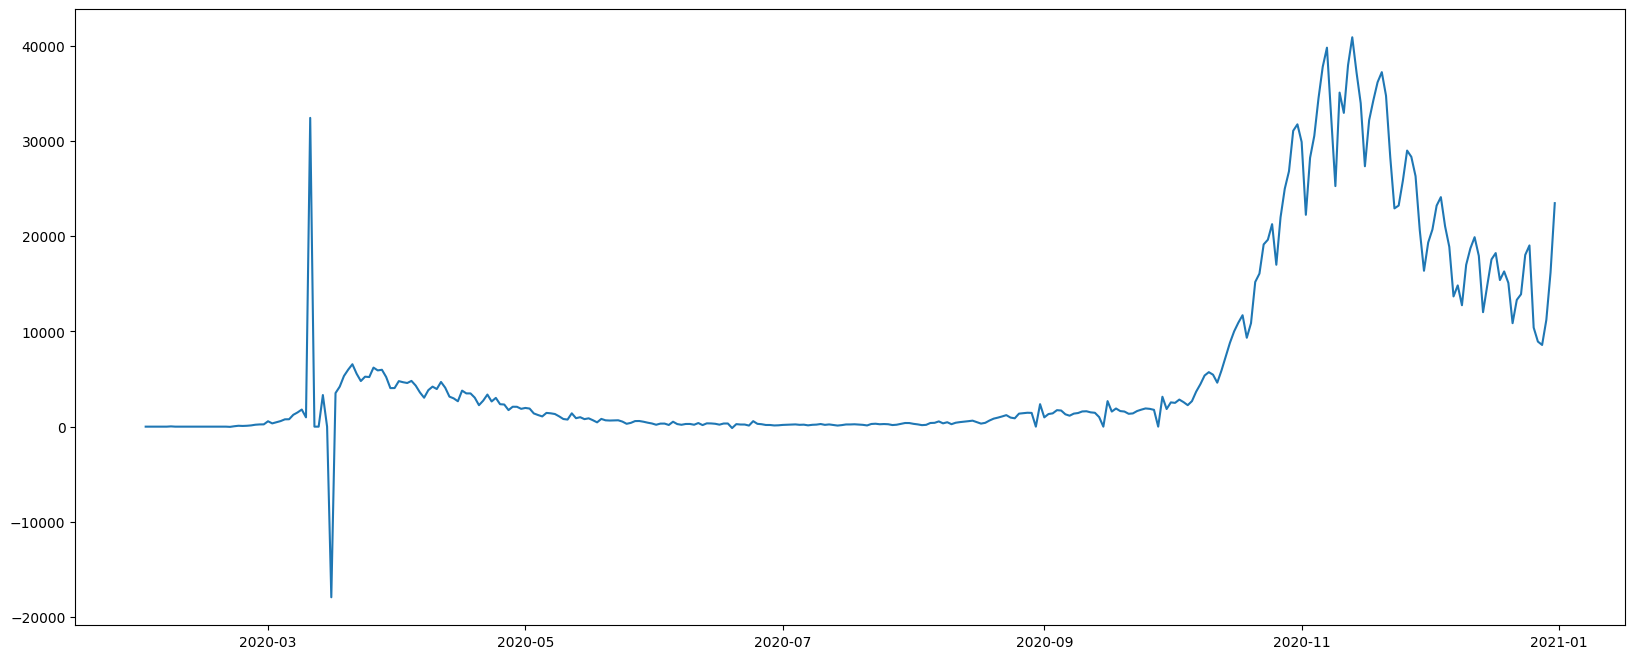

In [47]:
# visualize time serie after one differentation
fig = plt.figure(figsize=(20,8))
plt.plot(first_tdf)

ObservationDate
2020-02-01        0.0
2020-02-02        0.0
2020-02-03        0.0
2020-02-04        0.0
2020-02-05        0.0
2020-02-06        0.0
2020-02-07       28.0
2020-02-08        0.0
2020-02-09        0.0
2020-02-10        0.0
2020-02-11        0.0
2020-02-12        0.0
2020-02-13        0.0
2020-02-14        0.0
2020-02-15        0.0
2020-02-16        0.0
2020-02-17        0.0
2020-02-18        0.0
2020-02-19        0.0
2020-02-20        0.0
2020-02-21      -22.0
2020-02-22       42.0
2020-02-23       93.0
2020-02-24       74.0
2020-02-25       93.0
2020-02-26      131.0
2020-02-27      202.0
2020-02-28      233.0
2020-02-29      240.0
2020-03-01      566.0
2020-03-02      342.0
2020-03-03      466.0
2020-03-04      587.0
2020-03-05      769.0
2020-03-06      778.0
2020-03-07     1247.0
2020-03-08     1492.0
2020-03-09     1797.0
2020-03-10      977.0
2020-03-11    32435.0
2020-03-12        0.0
2020-03-13        0.0
2020-03-14     3320.0
2020-03-15        0.0
2020-03-16   -17

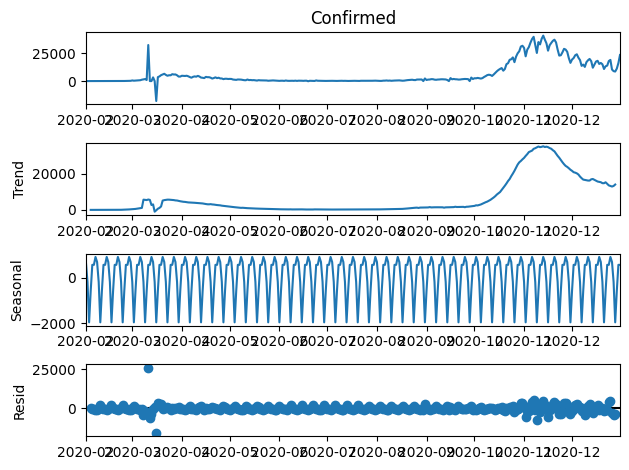

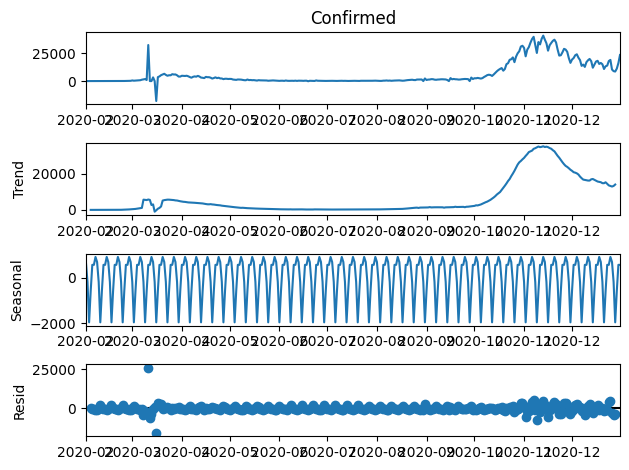

In [18]:
# visualize time serie after one differentation
first_tdf = first_tdf.dropna(inplace=False)
print(first_tdf)
decomposition = sm.tsa.seasonal_decompose(first_tdf, model='additive', period=7)
decomposition.plot()

In [19]:
# second difference
second_tdf = first_tdf - first_tdf.shift(1)
test_stationarity(second_tdf.dropna(inplace=False))

Test Statistic           -2.958302
p-value                   0.038976
Lags                     13.000000
Observations            320.000000
Critical Value (1%)      -3.450952
Critical Value (5%)      -2.870615
Critical Value (10%)     -2.571605
dtype: float64


In [20]:
print(second_tdf)

ObservationDate
2020-02-01        NaN
2020-02-02        0.0
2020-02-03        0.0
2020-02-04        0.0
2020-02-05        0.0
2020-02-06        0.0
2020-02-07       28.0
2020-02-08      -28.0
2020-02-09        0.0
2020-02-10        0.0
2020-02-11        0.0
2020-02-12        0.0
2020-02-13        0.0
2020-02-14        0.0
2020-02-15        0.0
2020-02-16        0.0
2020-02-17        0.0
2020-02-18        0.0
2020-02-19        0.0
2020-02-20        0.0
2020-02-21      -22.0
2020-02-22       64.0
2020-02-23       51.0
2020-02-24      -19.0
2020-02-25       19.0
2020-02-26       38.0
2020-02-27       71.0
2020-02-28       31.0
2020-02-29        7.0
2020-03-01      326.0
2020-03-02     -224.0
2020-03-03      124.0
2020-03-04      121.0
2020-03-05      182.0
2020-03-06        9.0
2020-03-07      469.0
2020-03-08      245.0
2020-03-09      305.0
2020-03-10     -820.0
2020-03-11    31458.0
2020-03-12   -32435.0
2020-03-13        0.0
2020-03-14     3320.0
2020-03-15    -3320.0
2020-03-16   -17

In [21]:
# delete first two null values of the new secondary differenciate time serie
second_tdf = second_tdf.dropna(inplace=False)
print(second_tdf)

ObservationDate
2020-02-02        0.0
2020-02-03        0.0
2020-02-04        0.0
2020-02-05        0.0
2020-02-06        0.0
2020-02-07       28.0
2020-02-08      -28.0
2020-02-09        0.0
2020-02-10        0.0
2020-02-11        0.0
2020-02-12        0.0
2020-02-13        0.0
2020-02-14        0.0
2020-02-15        0.0
2020-02-16        0.0
2020-02-17        0.0
2020-02-18        0.0
2020-02-19        0.0
2020-02-20        0.0
2020-02-21      -22.0
2020-02-22       64.0
2020-02-23       51.0
2020-02-24      -19.0
2020-02-25       19.0
2020-02-26       38.0
2020-02-27       71.0
2020-02-28       31.0
2020-02-29        7.0
2020-03-01      326.0
2020-03-02     -224.0
2020-03-03      124.0
2020-03-04      121.0
2020-03-05      182.0
2020-03-06        9.0
2020-03-07      469.0
2020-03-08      245.0
2020-03-09      305.0
2020-03-10     -820.0
2020-03-11    31458.0
2020-03-12   -32435.0
2020-03-13        0.0
2020-03-14     3320.0
2020-03-15    -3320.0
2020-03-16   -17924.0
2020-03-17    21

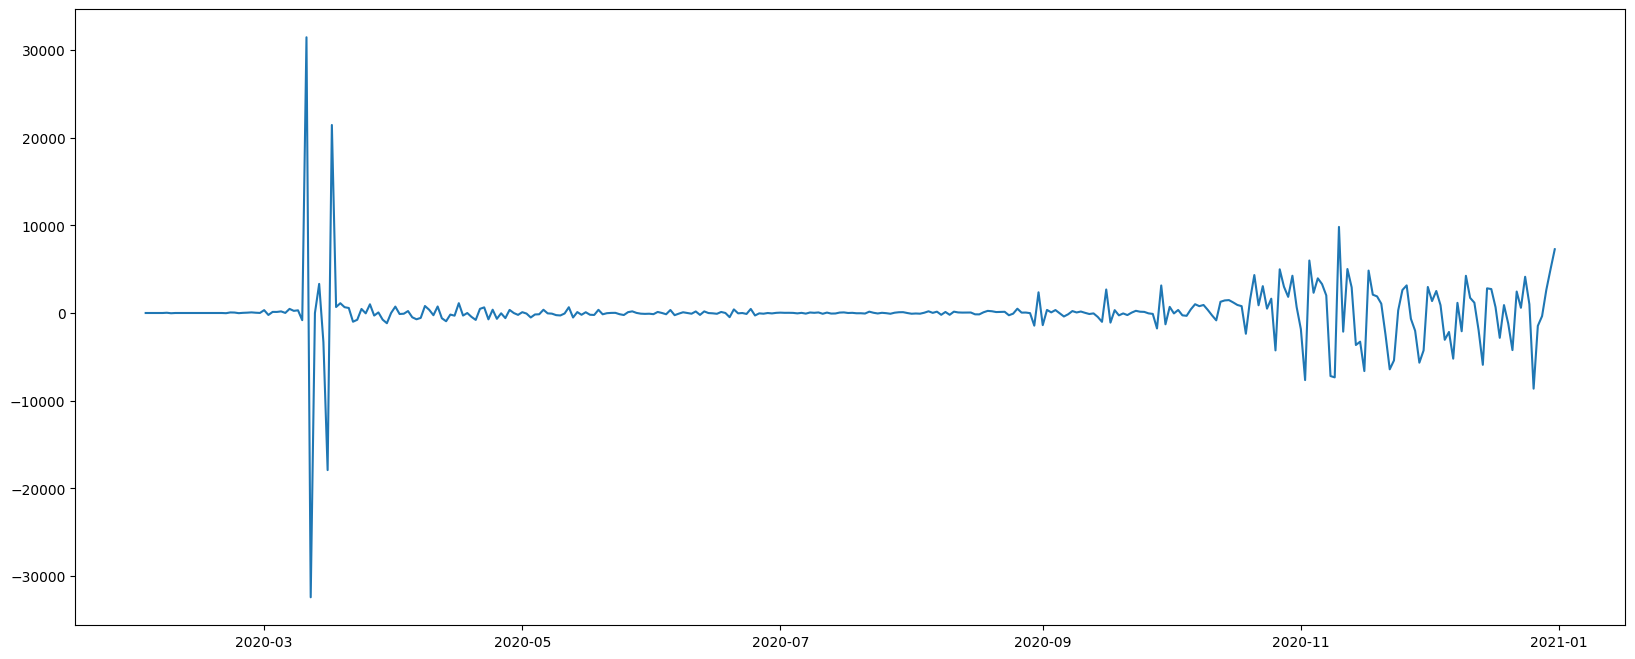

In [48]:
# visualize time serie after two differentation
fig = plt.figure(figsize=(20,8))
plt.plot(second_tdf)

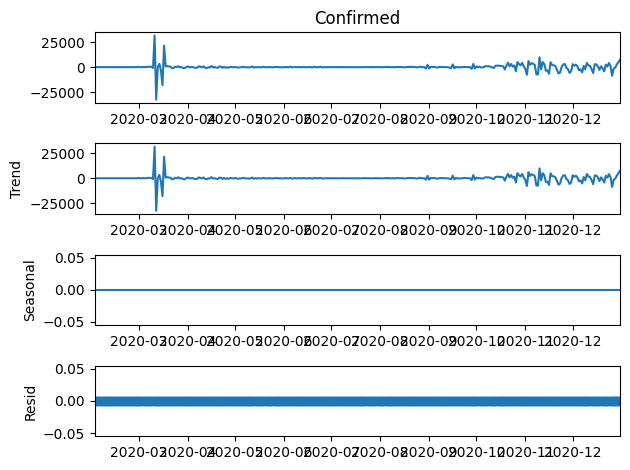

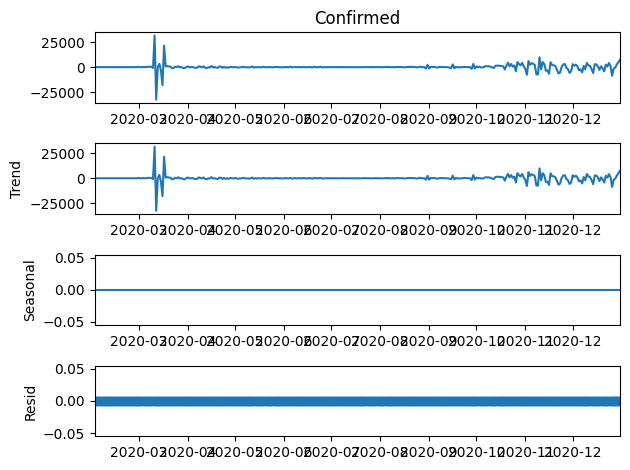

In [61]:
# visualize stationary time serie after two differentations

decomposition = sm.tsa.seasonal_decompose(second_tdf, model='additive', period=1)
decomposition.plot()

# Choose parameters for ARIMA
(not SARIMAX -> not seasonal component in our time series)
(not SARIMAX -> we don't have  Exogeneous variables in dataset (ex. temperature))

### ACF and PACF Graphs

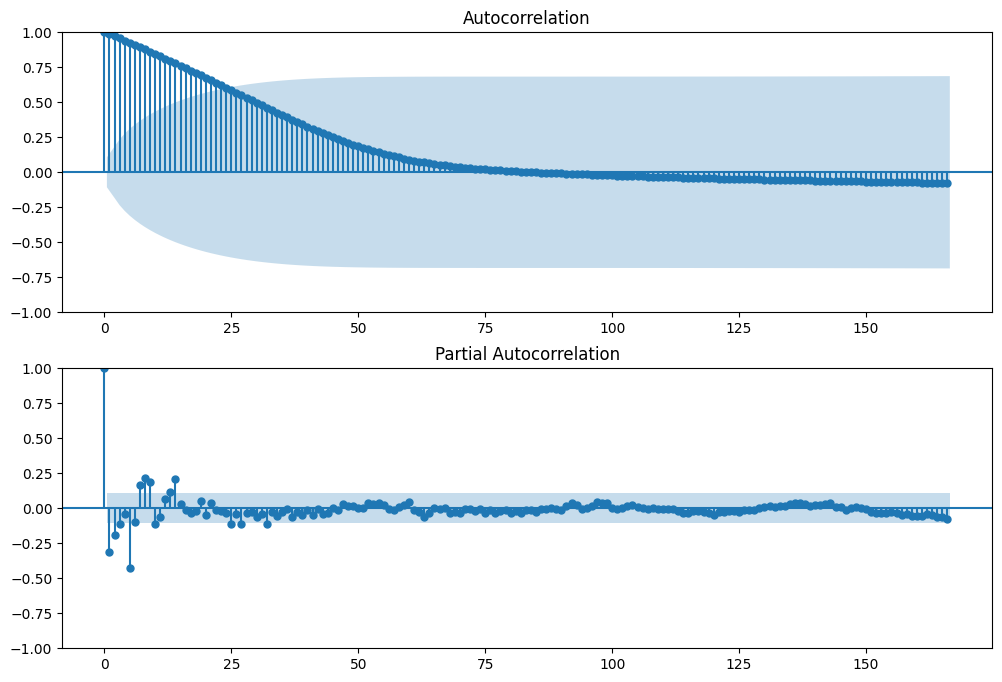

In [49]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tdf, lags=166, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(second_tdf, lags=166, ax=ax2)

# WITHOUD DIFFERENCIN MANY VALUES OUT OF AMMISSIBLE REGIONE -> TDF NOT STATIONARY

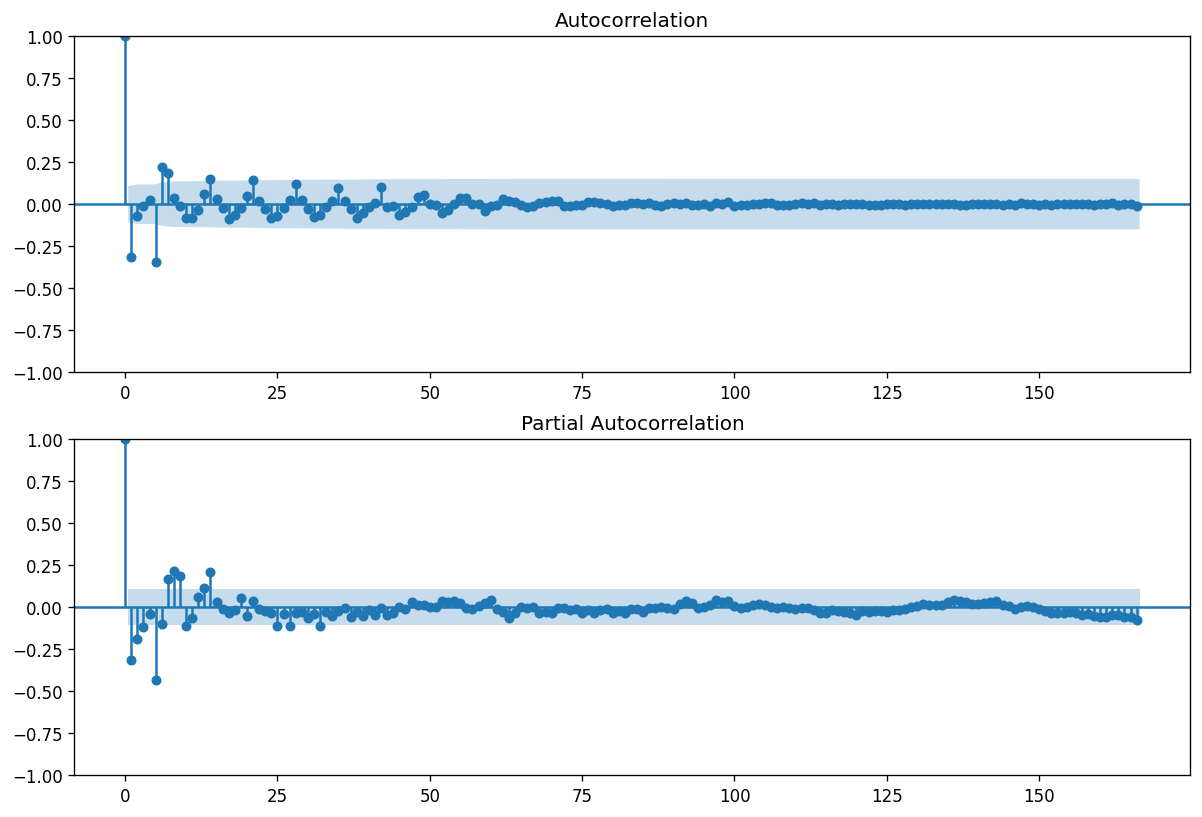

In [284]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(second_tdf, lags=166, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(second_tdf, lags=166, ax=ax2)


# p: how many values to consider for autoregression -> p = 1, 2 (3 limit, 1 o r 2 more significant beacuse of more distance from admissible area) (PACF)
# q: how many values to consider for moving average -> q = 1 (ACF)

# Varima? predict covid cases, recoverings and deaths?

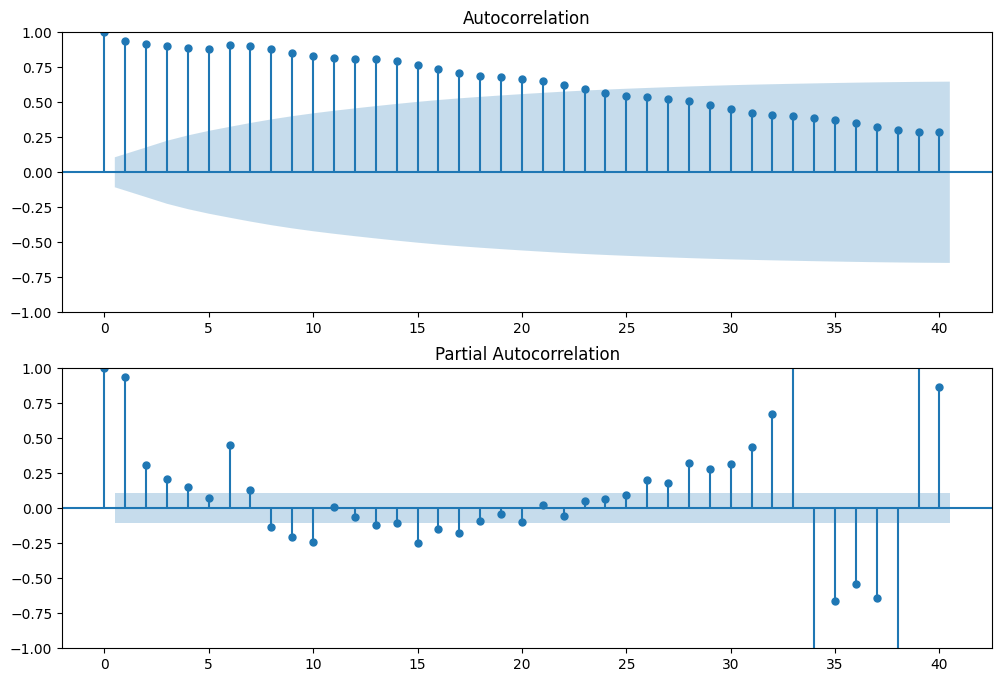

In [52]:
''' 
# AUTOCORRELATION WITH SECOND_TDF GOES MANY FAST TO BLUE AREA
# WE SHOULD TRY D=1 
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_tdf, lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_tdf, lags=40, ax=ax2)  
'''

# with d=1 many values before blue area -> d=2!


In [ ]:
"""  
# PARAMETER d to make serie a stationary serie
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({f'figure.figsize': (9,7), 'figure.dpi' :120})

# original series
fig, axes = plt.subplots (3, 2, sharex=True)
axes[0, 0].plot(tdf)
axes[0, 0].set_title ('Original Series')
plot_acf(tdf, ax=axes [0, 1], lags=335)


# 1st differencing

axes[1, 0].plot(tdf.diff())
axes[1, 0].set_title('1st Order Differencing')
# plot_acf(tdf.diff().dropna(), ax=axes [1, 1],lags=334)


# 2nd Differencing
axes[2, 0].plot(tdf.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
# plot_acf(tdf.diff().diff().dropna(), ax=axes [2, 1], lags=333)

plt.show()

"""


# ARIMA

## Fitting model

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  336
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -3163.164
Date:                Mon, 30 Jan 2023   AIC                           6334.327
Time:                        11:00:37   BIC                           6349.572
Sample:                    01-31-2020   HQIC                          6340.405
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2222      0.094      2.360      0.018       0.038       0.407
ar.L2         -0.0369      0.075     -0.491      0.623      -0.184       0.110
ma.L1         -0.6782      0.092     -7.406      0.000      -0.858      -0.499
sigma2      1.035e+07   1.98e+05     52.349      0.000    9.96e+06    1.07e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19559.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.60
Prob(H) (two-sided):                  0.05   Kurtosis:                        40.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

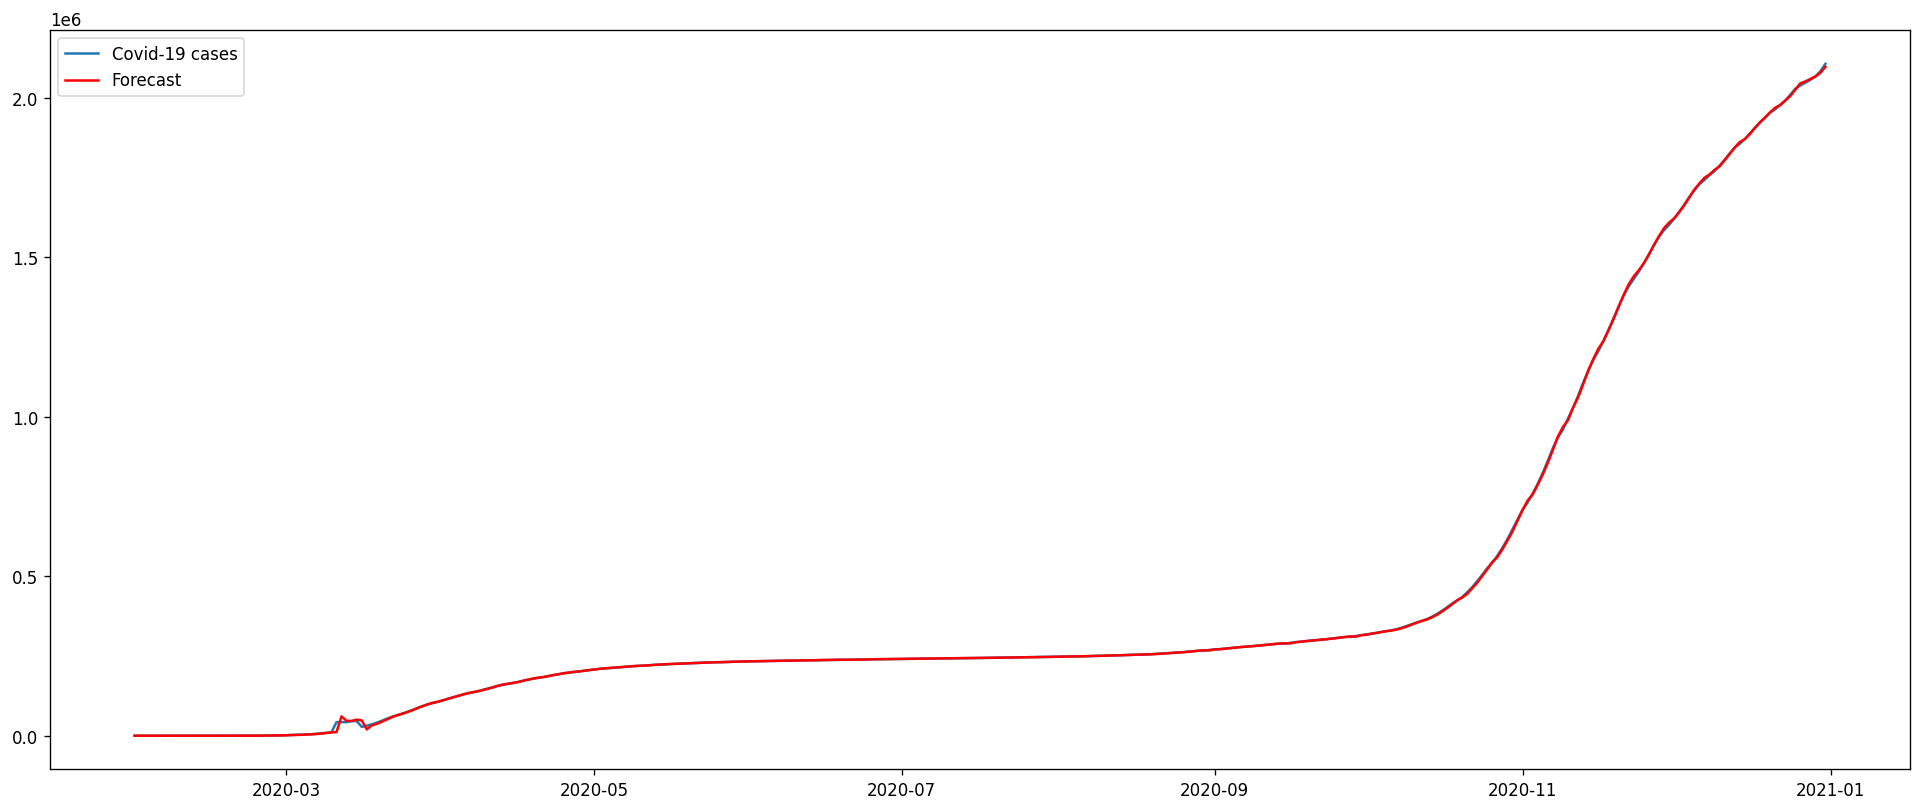

In [307]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(20,8))
model = ARIMA(tdf, order=(2,2,1)) # p, d, q
ax = plt.gca()
results = model.fit() 
plt.plot(tdf)
plt.plot(results.fittedvalues, color='red')
ax.legend(['Covid-19 cases', 'Forecast'])

results.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  336
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -3163.317
Date:                Mon, 30 Jan 2023   AIC                           6332.634
Time:                        18:03:19   BIC                           6344.067
Sample:                    01-31-2020   HQIC                          6337.193
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2343      0.061      3.849      0.000       0.115       0.354
ma.L1         -0.6959      0.056    -12.399      0.000      -0.806      -0.586
sigma2      1.035e+07   1.96e+05     52.664      0.000    9.96e+06    1.07e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             19263.09
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.60
Prob(H) (two-sided):                  0.05   Kurtosis:                        40.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

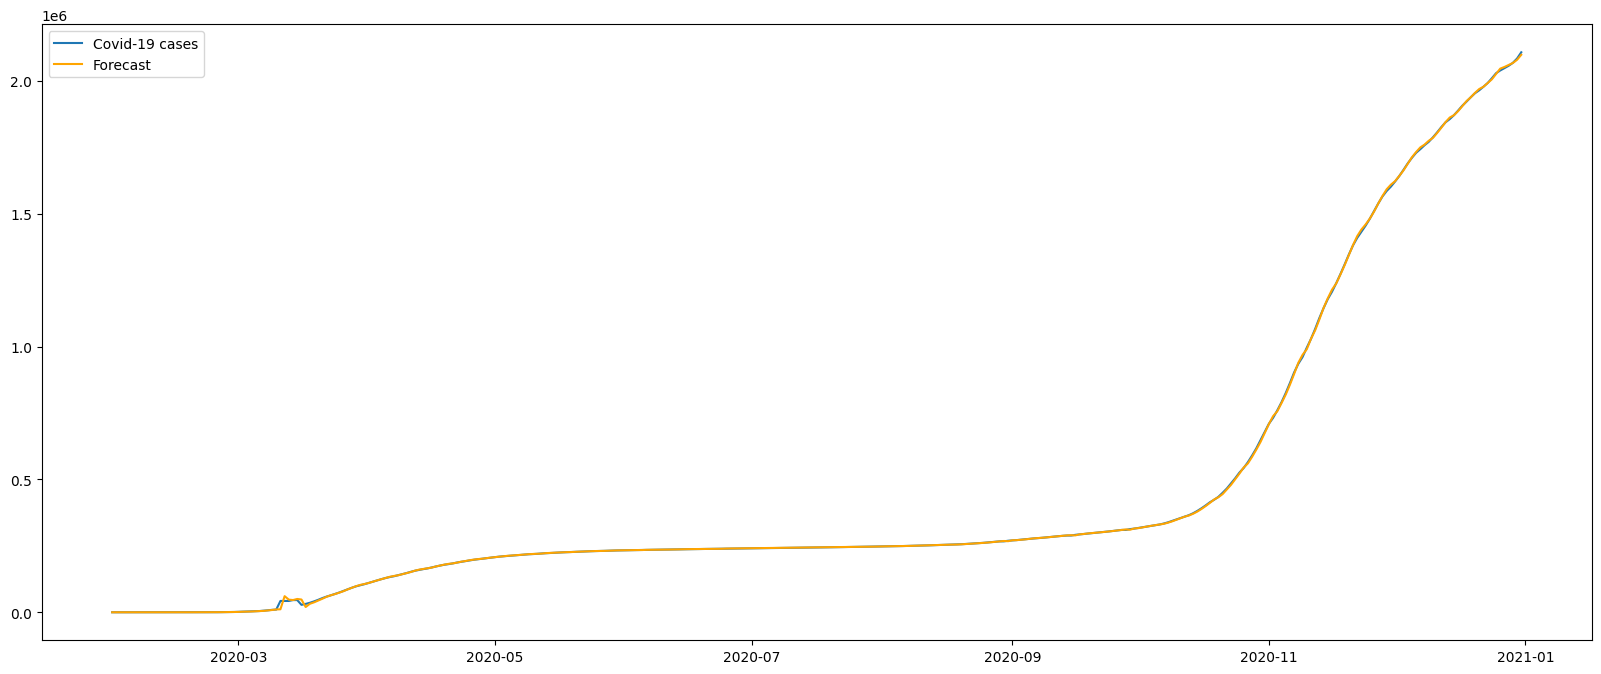

In [22]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(20,8))
model = ARIMA(tdf, order=(1,2,1)) # better with p = 1: aic is minor then p=2 and values of P>|z| are 0
ax = plt.gca()
results = model.fit() 
plt.plot(tdf)
plt.plot(results.fittedvalues, color='orange')
ax.legend(['Covid-19 cases', 'Forecast'])

results.summary()

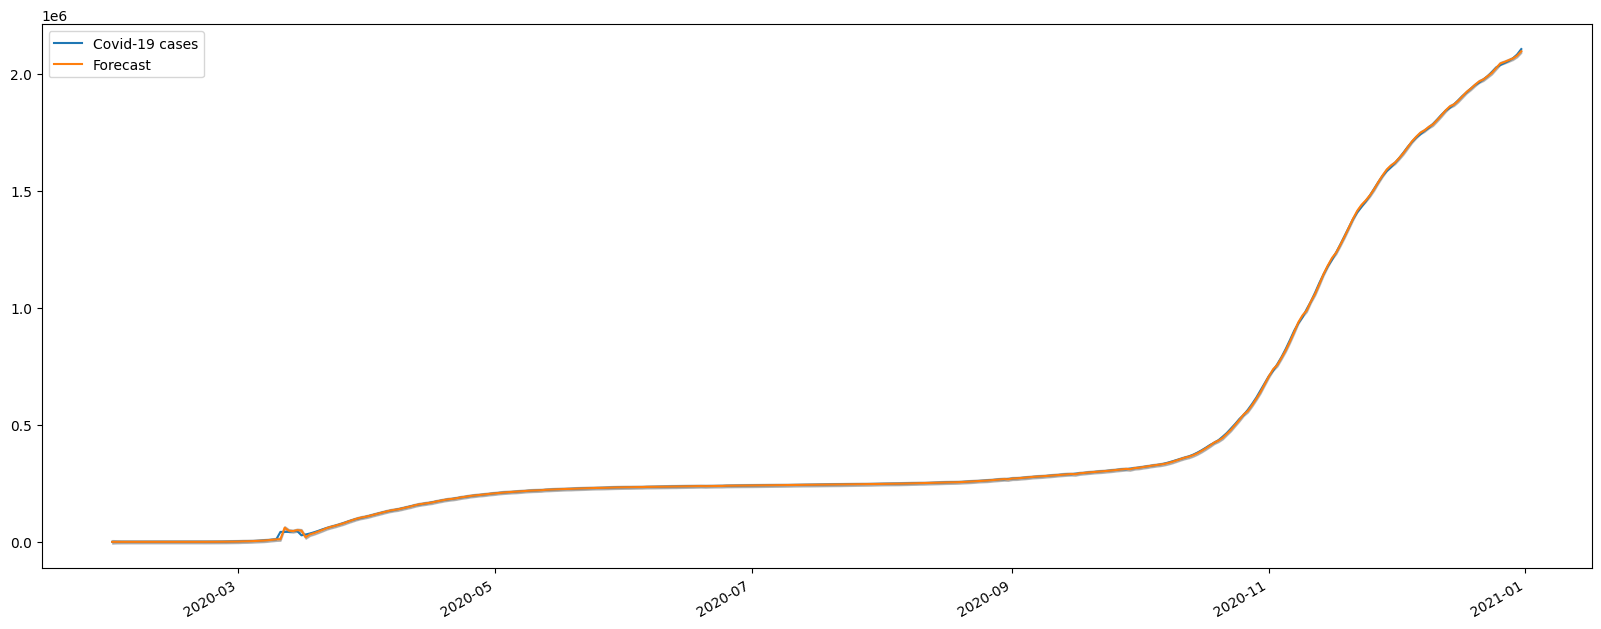

In [73]:
# TRY DYNAMIC
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

fig = plt.figure(figsize=(20,8))
model = ARIMA(tdf, order=(1,2,1)) # better with p = 1: aic is minor then p=2 and values of P>|z| are 0
ax = plt.gca()
results = model.fit() 
plt.plot(tdf)
plot_predict(results, ax=ax, dynamic=False) # with True no BAD RESULTS
ax.legend(['Covid-19 cases', 'Forecast'])



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  336
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -3163.164
Date:                Tue, 31 Jan 2023   AIC                           6334.327
Time:                        21:44:35   BIC                           6349.572
Sample:                    01-31-2020   HQIC                          6340.405
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2222      0.094      2.360      0.018       0.038       0.407
ar.L2         -0.0369      0.075     -0.491      0.623      -0.184       0.110
ma.L1         -0.6782      0.092     -7.406      0.000      -0.858      -0.499
sigma2      1.035e+07   1.98e+05     52.349      0.000    9.96e+06    1.07e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19559.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.60
Prob(H) (two-sided):                  0.05   Kurtosis:                        40.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

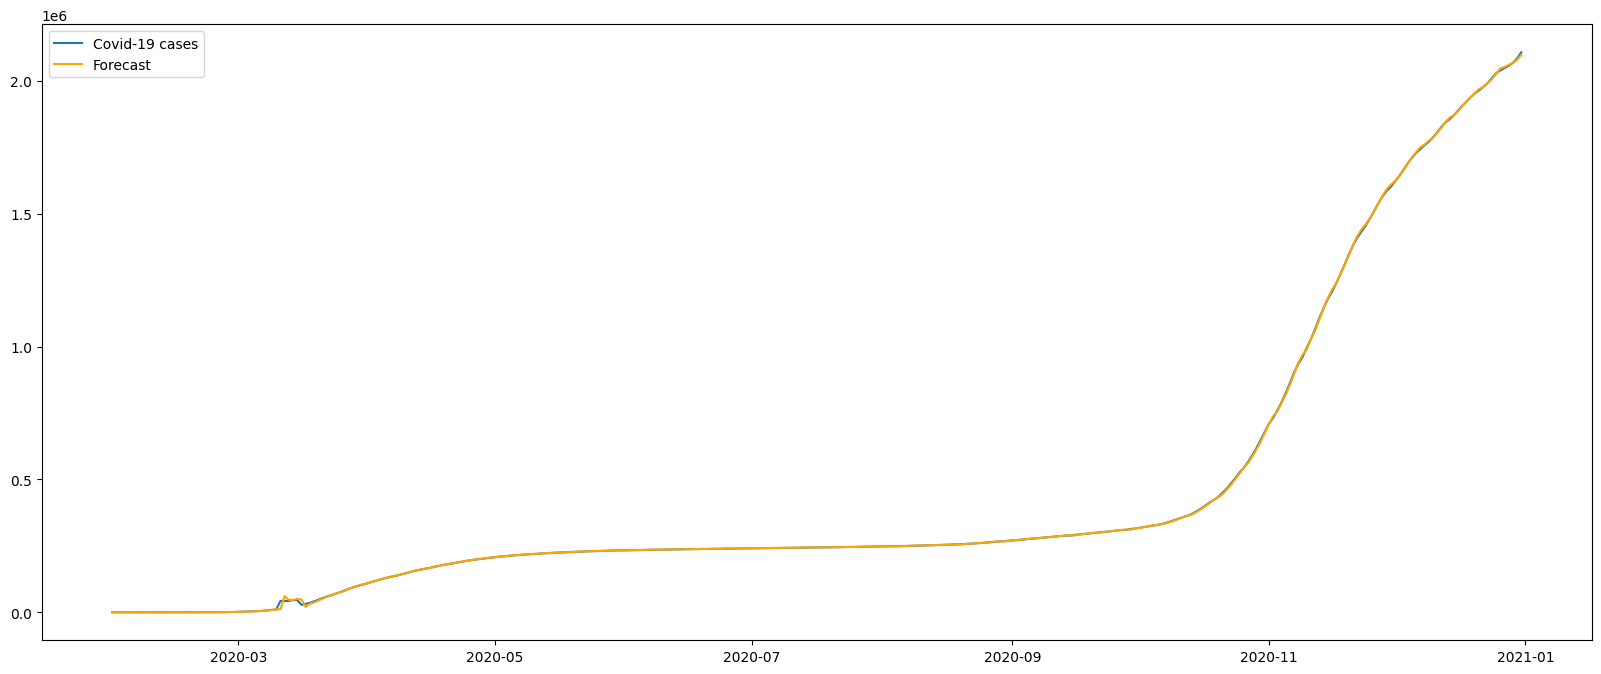

In [63]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(20,8))
model = ARIMA(tdf, order=(2,2,1)) # p, d, q
ax = plt.gca()
results = model.fit() 
plt.plot(tdf)
plt.plot(results.fittedvalues, color='orange')
ax.legend(['Covid-19 cases', 'Forecast'])

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  336
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -3162.574
Date:                Tue, 31 Jan 2023   AIC                           6335.148
Time:                        21:39:49   BIC                           6354.203
Sample:                    01-31-2020   HQIC                          6342.746
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1823      0.105      1.740      0.082      -0.023       0.388
ar.L2         -0.0431      0.071     -0.605      0.545      -0.183       0.097
ar.L3         -0.0699      0.053     -1.326      0.185      -0.173       0.033
ma.L1         -0.6404      0.103     -6.200      0.000      -0.843      -0.438
sigma2      1.035e+07   2.04e+05     50.812      0.000    9.95e+06    1.07e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             20358.33
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             1.57
Prob(H) (two-sided):                  0.03   Kurtosis:                        41.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

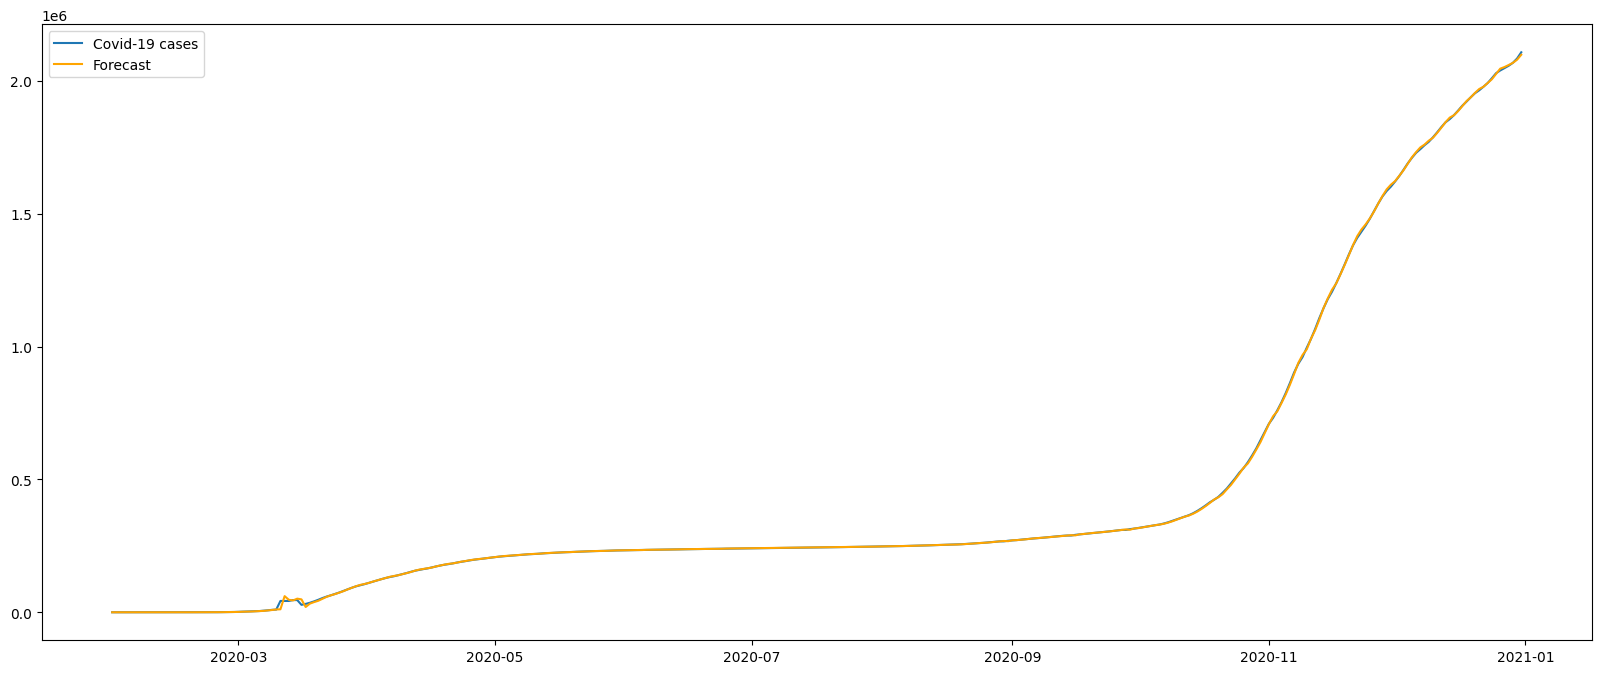

In [62]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(20,8))
model = ARIMA(tdf, order=(3,2,1)) # better with p = 1: aic is minor then p=2 and values of P>|z| are 0
ax = plt.gca()
results = model.fit() 
plt.plot(tdf)
plt.plot(results.fittedvalues, color='orange')
ax.legend(['Covid-19 cases', 'Forecast'])

results.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  336
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3482.844
Date:                Mon, 30 Jan 2023   AIC                           6973.688
Time:                        10:49:41   BIC                           6988.956
Sample:                    01-31-2020   HQIC                          6979.774
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.507e+05    4.9e-12    9.2e+16      0.000    4.51e+05    4.51e+05
ar.L1          0.9999      0.000   7305.527      0.000       1.000       1.000
ma.L1          0.7508      0.020     37.765      0.000       0.712       0.790
sigma2      5.712e+07   3.41e-12   1.67e+19      0.000    5.71e+07    5.71e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.95   Jarque-Bera (JB):               243.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.93   Skew:                             1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.12e+35. Standard errors may be unstable.
"""

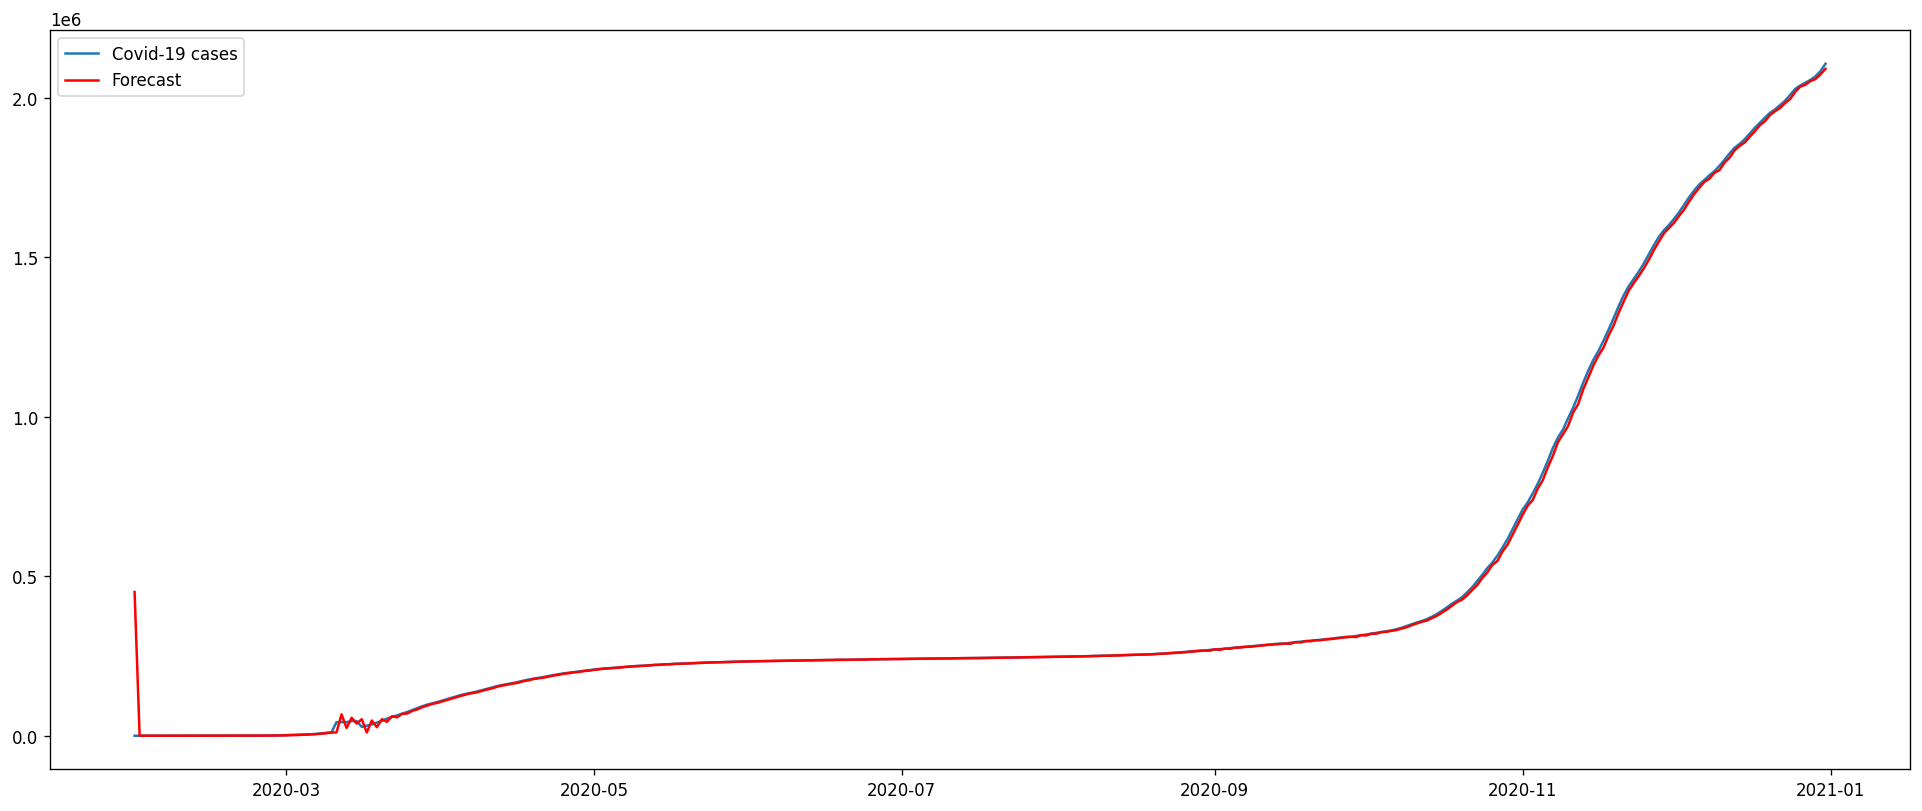

In [297]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(20,8))
model = ARIMA(tdf, order=(1,0,1)) # without stationary series -> worste
ax = plt.gca()
results = model.fit() 
plt.plot(tdf)
plt.plot(results.fittedvalues, color='red')
ax.legend(['Covid-19 cases', 'Forecast'])

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  336
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -3192.873
Date:                Tue, 31 Jan 2023   AIC                           6395.745
Time:                        20:00:19   BIC                           6414.831
Sample:                    01-31-2020   HQIC                          6403.353
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.507e+05   1.35e-10   3.33e+15      0.000    4.51e+05    4.51e+05
ar.L1          1.9934      0.006    359.211      0.000       1.983       2.004
ar.L2         -0.9935      0.006   -176.593      0.000      -1.005      -0.982
ma.L1         -0.5567      0.020    -27.904      0.000      -0.596      -0.518
sigma2      1.079e+07   2.11e-10   5.11e+16      0.000    1.08e+07    1.08e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.38   Jarque-Bera (JB):             15667.12
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             1.71
Prob(H) (two-sided):                  0.20   Kurtosis:                        36.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.1e+33. Standard errors may be unstable.
"""

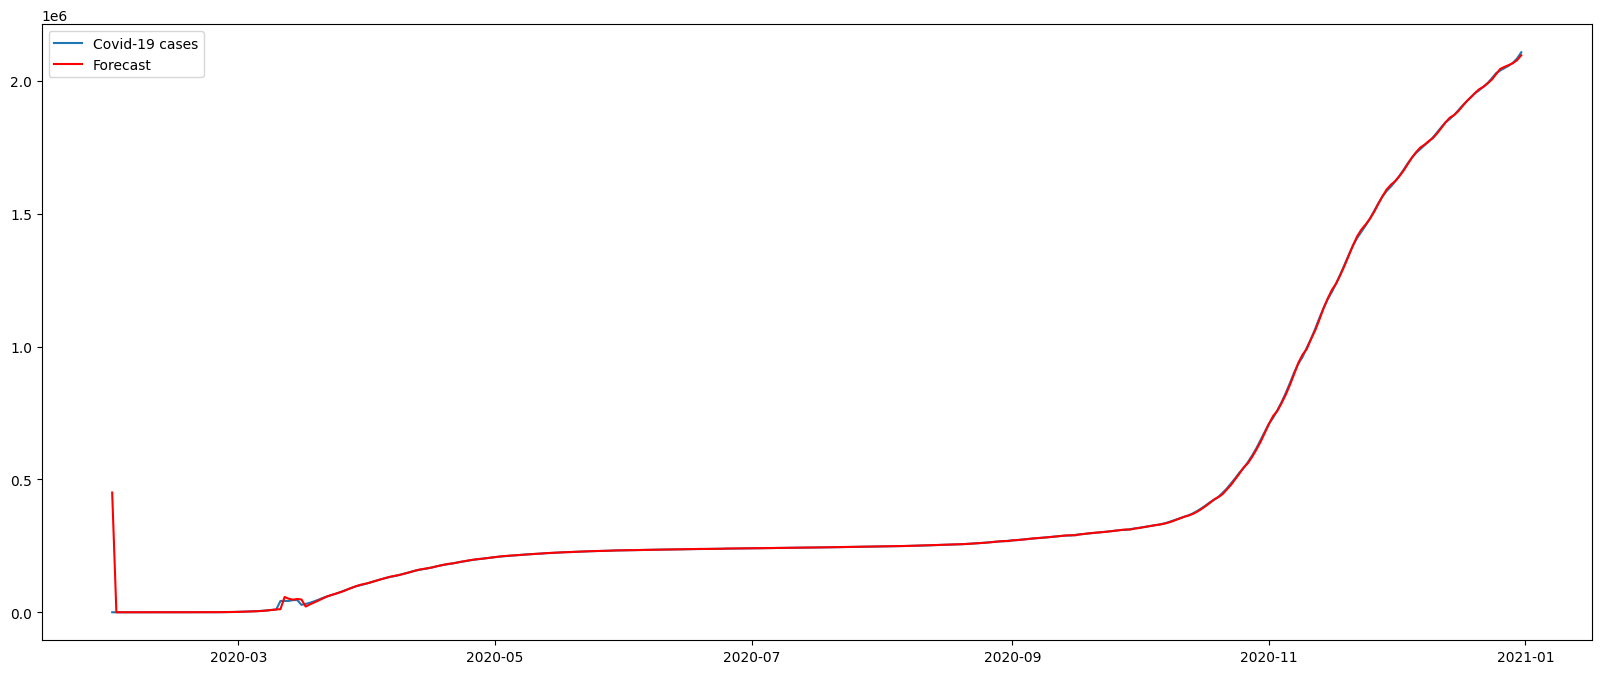

In [53]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(20,8))
model = ARIMA(tdf, order=(2,0,1)) # without stationary series 
ax = plt.gca()
results = model.fit() 
plt.plot(tdf)
plt.plot(results.fittedvalues, color='red')
ax.legend(['Covid-19 cases', 'Forecast'])

results.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  336
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -3178.527
Date:                Mon, 30 Jan 2023   AIC                           6361.053
Time:                        10:54:01   BIC                           6368.676
Sample:                    01-31-2020   HQIC                          6364.092
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3175      0.013    -23.618      0.000      -0.344      -0.291
sigma2      1.083e+07   2.11e+05     51.432      0.000    1.04e+07    1.12e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):             16538.56
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

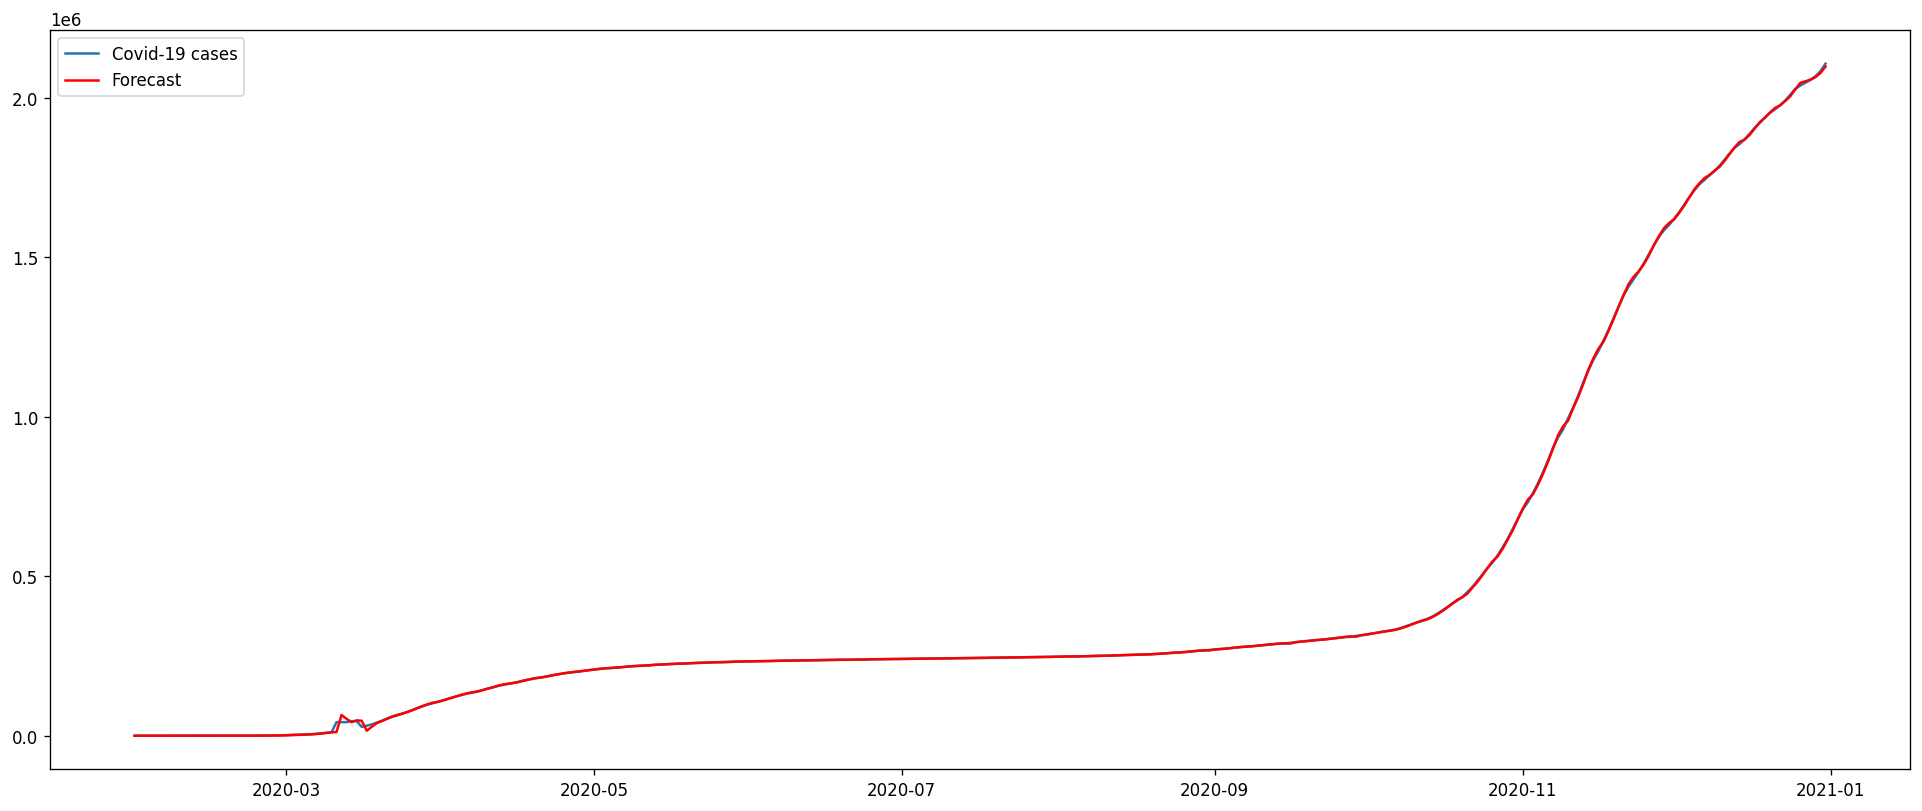

In [299]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(20,8))
model = ARIMA(tdf, order=(1,2,0)) # not better with p = 1: aic is minor then qith p=2 -> worste, but q doesn't influence so much
ax = plt.gca()
results = model.fit() 
plt.plot(tdf)
plt.plot(results.fittedvalues, color='red')
ax.legend(['Covid-19 cases', 'Forecast'])

results.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                  336
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3618.239
Date:                Mon, 30 Jan 2023   AIC                           7238.478
Time:                        10:55:28   BIC                           7242.292
Sample:                    01-31-2020   HQIC                          7239.998
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.405e+08   6.75e+06     20.824      0.000    1.27e+08    1.54e+08
===================================================================================
Ljung-Box (L1) (Q):                 296.16   Jarque-Bera (JB):               226.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              20.49   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

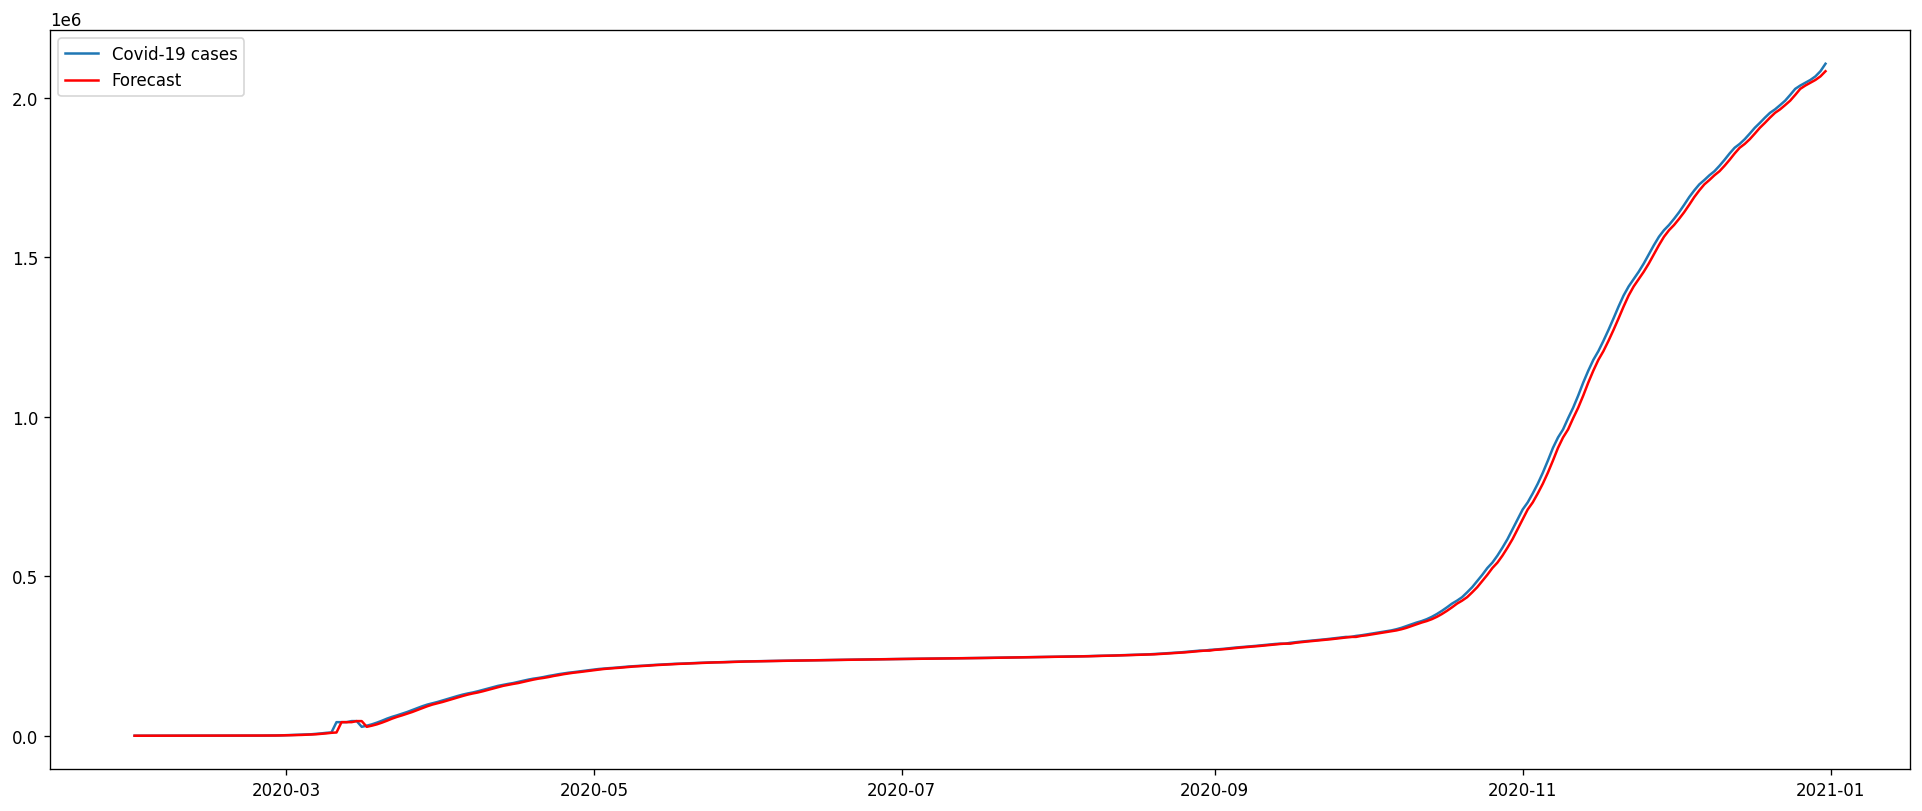

In [303]:
# fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(20,8))
model = ARIMA(tdf, order=(0,1,0)) # not better with 0,1,0: but good result, the parameter that influens more is d!
ax = plt.gca()
results = model.fit() 
plt.plot(tdf)
plt.plot(results.fittedvalues, color='red')
ax.legend(['Covid-19 cases', 'Forecast'])

results.summary()

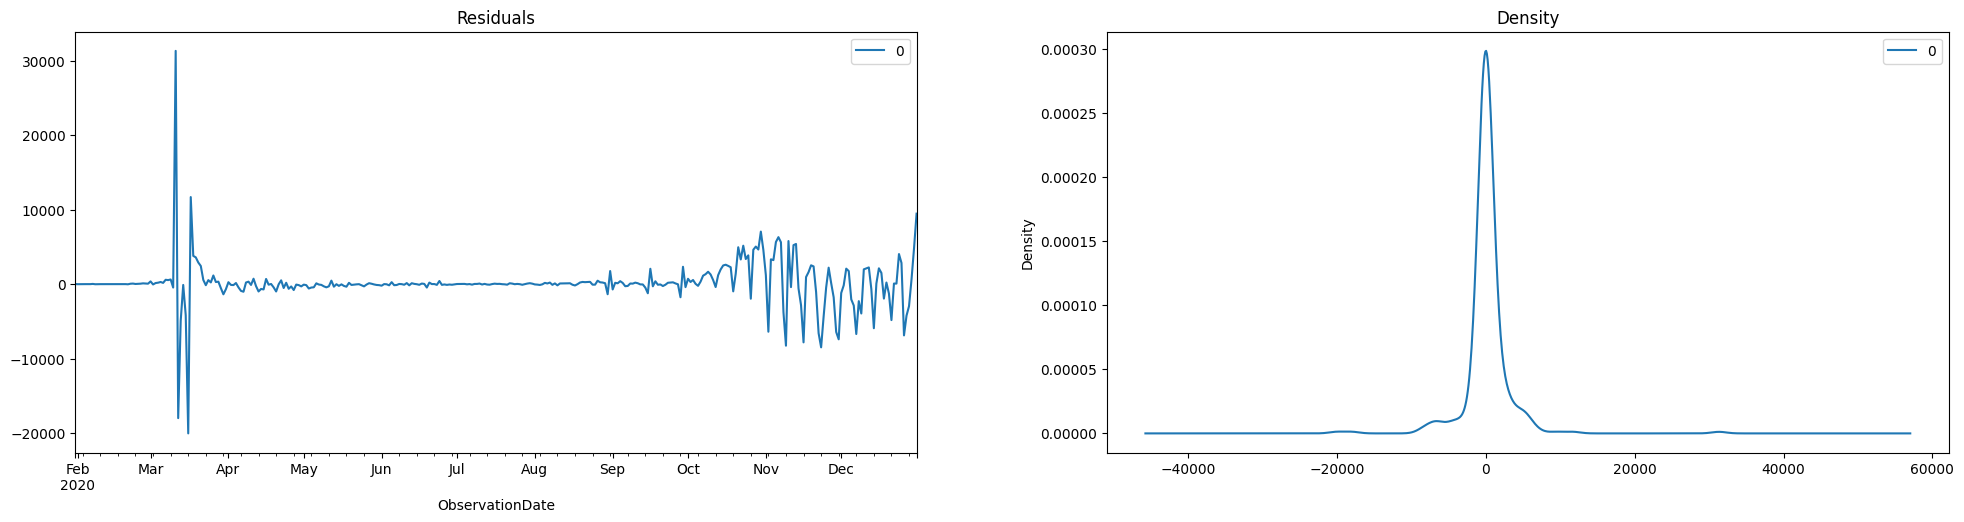

In [36]:
# check mean and variance of residuals -> USE RESULTS OF ARIMA(1,2,1)
# Plot residual errors
residuals = pd.DataFrame(results.resid)

fig, ax = plt.subplots(1, 2)
fig.tight_layout(h_pad=4)
plt.subplots_adjust(right=3)

residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

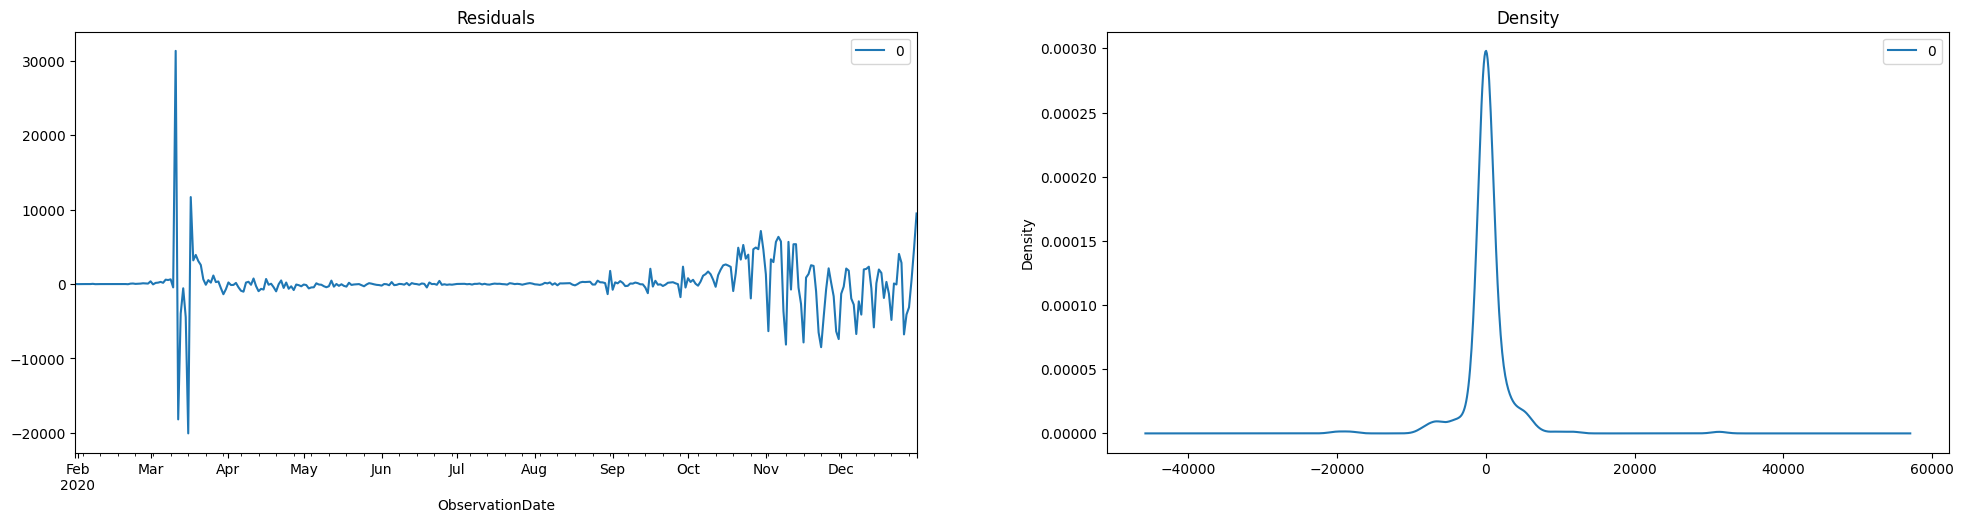

In [65]:
# residuals for 221
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(tdf, order=(2,2,1)) # p, d, q
results = model.fit() 

residuals = pd.DataFrame(results.resid)

fig, ax = plt.subplots(1, 2)
fig.tight_layout(h_pad=4)
plt.subplots_adjust(right=3)

residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [312]:
"""   
# Setup forecasts # -> tutto il pezzo fatto prima, ma messo insieme

training_obs = int(len(endog) * 0.8) # prendo 80% dei dati
training_tdf = tdf[:training_obs]


nforecasts = 3 # quanti forecast fare ad ogni iterazione per fare forecast
forecasts = {}

# Get the number of initial training observations
nobs = len(tdf)
n_init_training = int(nobs * 0.8)

# Create model for initial training sample, fit parameters
init_training_tdf = tdf.iloc[:n_init_training]
mod = sm.tsa.ARIMA(training_tdf, order=(1, 2, 1))
res = mod.fit()

# Save initial forecast
forecasts[training_tdf.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs): # ciclo for per scorrere serie temporale punto per punto e ogni volta metto alla prova il mio modello
    # Update the results by appending the next observation
    updated_tdf = tdf.iloc[t:t+1]
    res = res.append(updated_tdf, refit=False) # refit per riallenare o meno modello su quella osservazione
    # Save the new set of forecasts
    forecasts[updated_tdf.index[0]] = res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])

"""


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


               2020-10-24     2020-10-25     2020-10-26     2020-10-27  \
2020-10-25  520162.346950            NaN            NaN            NaN   
2020-10-26  535729.436280  542920.092286            NaN            NaN   
2020-10-27  551294.659288  559968.719225  559800.979416            NaN   
2020-10-28            NaN  577015.410439  576813.066569  583181.438893   
2020-10-29            NaN            NaN  593825.156053  601507.298433   

               2020-10-28  
2020-10-25            NaN  
2020-10-26            NaN  
2020-10-27            NaN  
2020-10-28            NaN  
2020-10-29  609932.607513  


ObservationDate
2020-01-31        14.0
2020-02-01        14.0
2020-02-02        14.0
2020-02-03        14.0
2020-02-04        14.0
2020-02-05        14.0
2020-02-06        14.0
2020-02-07        42.0
2020-02-08        42.0
2020-02-09        42.0
2020-02-10        42.0
2020-02-11        42.0
2020-02-12        42.0
2020-02-13        42.0
2020-02-14        42.0
2020-02-15        42.0
2020-02-16        42.0
2020-02-17        42.0
2020-02-18        42.0
2020-02-19        42.0
2020-02-20        42.0
2020-02-21        20.0
2020-02-22        62.0
2020-02-23       155.0
2020-02-24       229.0
2020-02-25       322.0
2020-02-26       453.0
2020-02-27       655.0
2020-02-28       888.0
2020-02-29      1128.0
2020-03-01      1694.0
2020-03-02      2036.0
2020-03-03      2502.0
2020-03-04      3089.0
2020-03-05      3858.0
2020-03-06      4636.0
2020-03-07      5883.0
2020-03-08      7375.0
2020-03-09      9172.0
2020-03-10     10149.0
2020-03-11     42584.0
2020-03-12     42584.0
2020-03-13     425

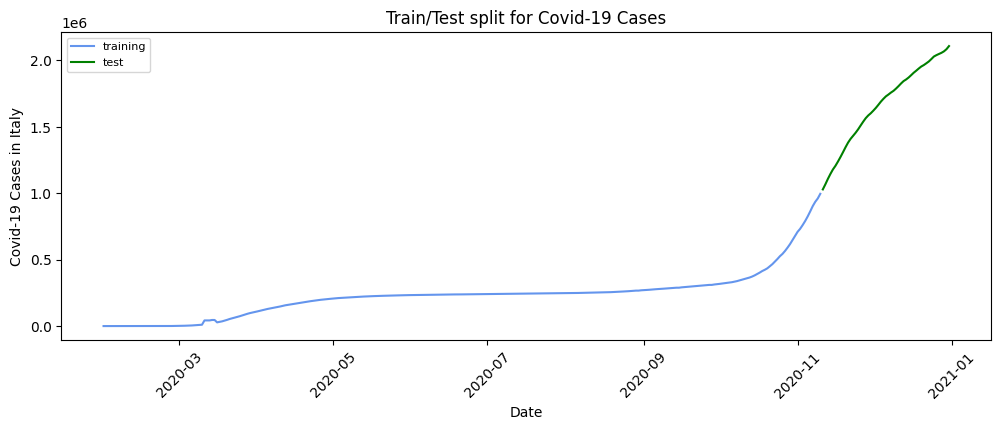

In [37]:
# Create Training and Test
n = 85 # percentage of dataset to use as training set
m = 100 - n
train = tdf.head(int(len(tdf)*(n/100)))

test = tdf.tail(int(len(tdf)*(m/100))+1)
print(train)
print(test)

plt.figure(figsize=(12,4))
plt.plot(train, color = "cornflowerblue", label='training')
plt.plot(test, color = "green", label='test')
plt.ylabel('Covid-19 Cases in Italy')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Covid-19 Cases")
plt.legend(loc='upper left', fontsize=8)
plt.show()



In [38]:
print(train.shape)
print(test.shape)

(285,)
(51,)


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


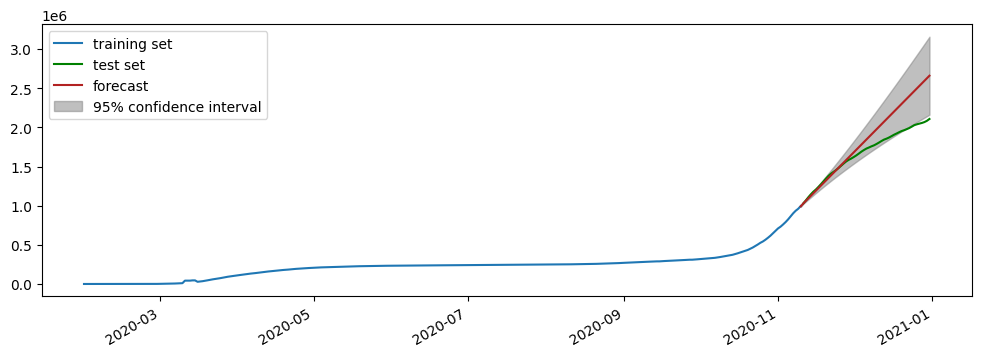

In [39]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
import matplotlib as mpl
from matplotlib.rcsetup import cycler
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA


with mpl.rc_context():
    # mpl.rc('axes', prop_cycle=['#0000FF', '#FF6600'])
    mpl.rcParams['axes.prop_cycle'] = cycler(color=['firebrick'])
    # Build Model
    model = ARIMA(train, order=(1, 2, 1)) 
    model_fit = model.fit()

    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(pd.DataFrame(train), label='training set', color = "tab:blue")
    ax.plot(test, color = "green", label='test set')
  
    plot_predict(model_fit, start=284, end=335, ax=ax) # train 85 # end train 335
    # plot_predict(model_fit, start=300, end=335, ax=ax) # train 90

# Metrics for forecast in sample

In [40]:
from sklearn.metrics import r2_score

def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))
    mbe = np.mean(forecast - actual)
    # mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    rmse = np.sqrt(np.mean(np.power(forecast - actual, 2)))
    r2 = r2_score(actual, forecast)

    return({'MAE':mae,'MBE':mbe, 'RMSE':rmse, 'r2':r2})

fc = model_fit.forecast(len(test), alpha=0.05) # 95% confidence

forecast_accuracy(fc, test)


# mae -> metric ok, but not direction of error
# mbe -> we can see bias positive because is > 0 

{'MAE': 182538.49934061978,
 'MBE': 174356.21130859695,
 'RMSE': 255233.821796665,
 'r2': 0.30062806858069446}

# With d=0 and p=2

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

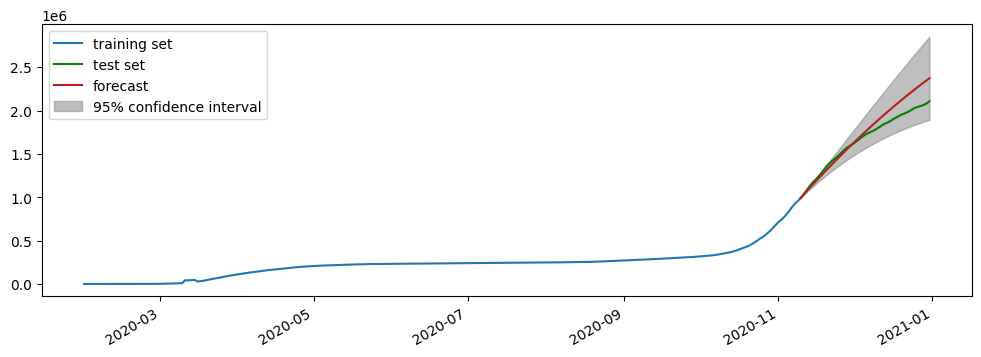

In [41]:
with mpl.rc_context():
    # mpl.rc('axes', prop_cycle=['#0000FF', '#FF6600'])
    mpl.rcParams['axes.prop_cycle'] = cycler(color=['firebrick'])
    # Build Model
    model = ARIMA(train, order=(2, 0, 1)) 
    model_fit = model.fit()

    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(pd.DataFrame(train), label='training set', color = "tab:blue")
    ax.plot(test, color = "green", label='test set')
  
    plot_predict(model_fit, start=284, end=335, ax=ax) # train 85 # end train 335
    # plot_predict(model_fit, start=300, end=335, ax=ax) # train 90

In [42]:
fc = model_fit.forecast(len(test), alpha=0.05) # 95% confidence

forecast_accuracy(fc, test)


{'MAE': 91619.7297631073,
 'MBE': 73734.40035339542,
 'RMSE': 124559.58190505378,
 'r2': 0.8334341233271391}

# Find best parameters

In [43]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.85)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
 dataset = dataset.astype('float32')
 best_score, best_cfg = float("inf"), None
 for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                rmse = evaluate_arima_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
            except:
                continue
 print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 

# evaluate parameters
p_values = [0, 1, 2, 3]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(tdf, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1360308.632
ARIMA(0, 0, 1) RMSE=689620.602
ARIMA(0, 0, 2) RMSE=370471.230
ARIMA(0, 1, 0) RMSE=23406.217
ARIMA(0, 1, 1) RMSE=13744.340
ARIMA(0, 1, 2) RMSE=9024.815
ARIMA(0, 2, 0) RMSE=3550.653
Best ARIMA(0, 2, 0) RMSE=3550.653


## With best parameters found out with grid search

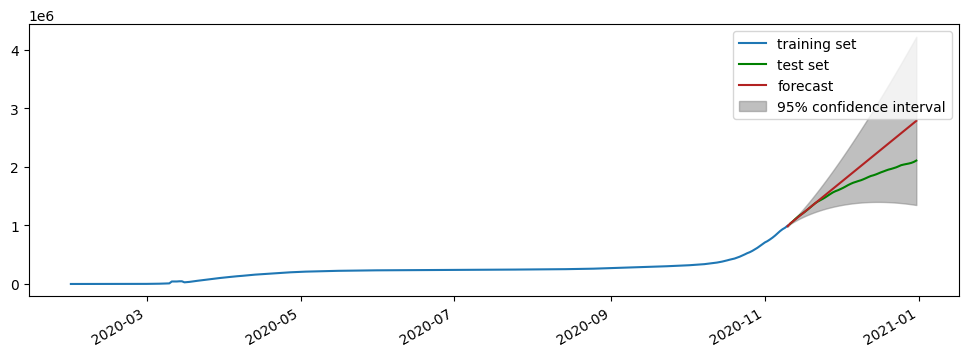

In [44]:
with mpl.rc_context():
    # mpl.rc('axes', prop_cycle=['#0000FF', '#FF6600'])
    mpl.rcParams['axes.prop_cycle'] = cycler(color=['firebrick'])
    # Build Model
    model = ARIMA(train, order=(0, 2, 0)) 
    model_fit = model.fit()

    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(pd.DataFrame(train), label='training set', color = "tab:blue")
    ax.plot(test, color = "green", label='test set')
  
    plot_predict(model_fit, start=284, end=335, ax=ax) # train 85 # end train 335
    # plot_predict(model_fit, start=300, end=335, ax=ax) # train 90

In [45]:
fc = model_fit.forecast(len(test), alpha=0.05) # 95% confidence

forecast_accuracy(fc, test)


{'MAE': 239214.9411764706,
 'MBE': 238286.58823529413,
 'RMSE': 325318.1686687062,
 'r2': -0.13618326704257977}

# Forecast out of sample

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/var/folders/k8/b6lhrl0x45g7kg3gtvt0n1240000gn/T/ipykernel_20238/1347239916.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-g" (-> color='g'). The keyword argument will take precedence.
  ax.plot(pd.DataFrame(tdf), '-g', label='Covid-19 cases', color='tab:blue')


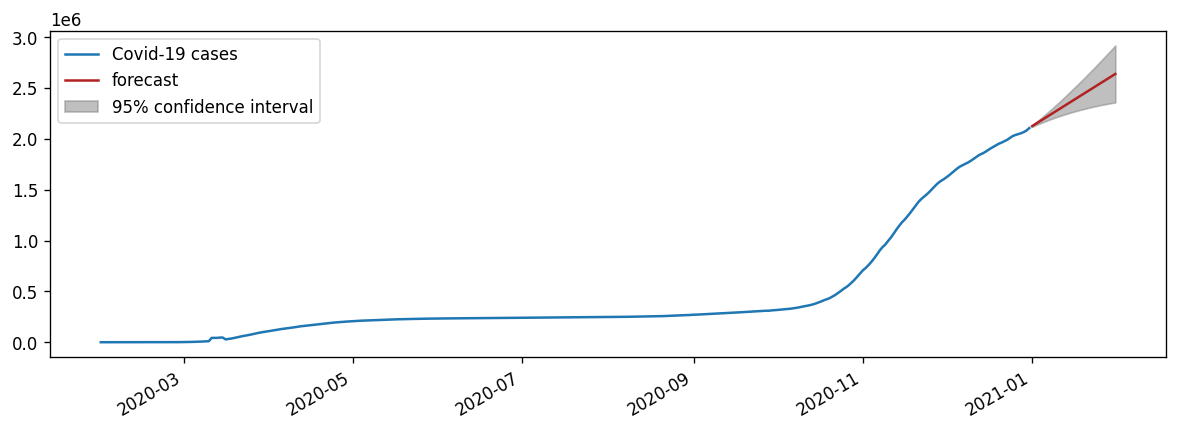

In [487]:
import matplotlib as mpl
from matplotlib.rcsetup import cycler
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

# Build Model


with mpl.rc_context():
    # mpl.rc('axes', prop_cycle=['#0000FF', '#FF6600'])
    mpl.rcParams['axes.prop_cycle'] = cycler(color=['firebrick'])
    model = ARIMA(tdf, order=(1, 2, 1)) 
    model_fit = model.fit()
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(pd.DataFrame(tdf), '-g', label='Covid-19 cases', color='tab:blue')
    # ax.plot(test, color = "green", label='test set')

    # plot_predict(model_fit, start=335, end=366, ax=ax)
    plot_predict(model_fit, start='2021-01-01', end='2021-01-31', ax=ax)



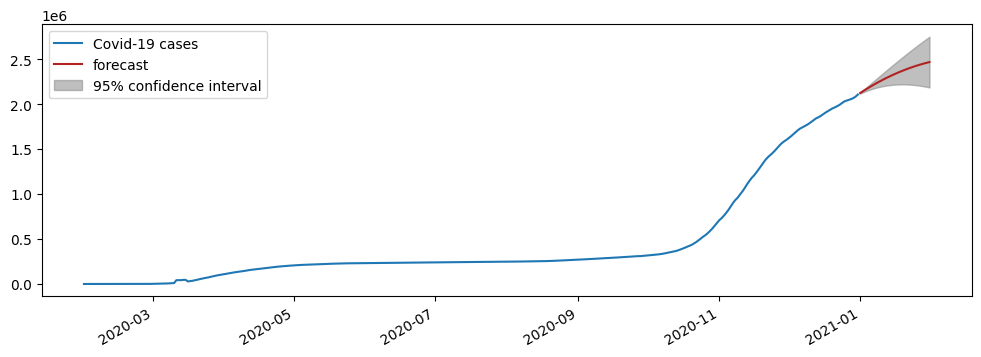

In [46]:
import matplotlib as mpl
from matplotlib.rcsetup import cycler
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

# Build Model


with mpl.rc_context():
    # mpl.rc('axes', prop_cycle=['#0000FF', '#FF6600'])
    mpl.rcParams['axes.prop_cycle'] = cycler(color=['firebrick'])
    model = ARIMA(tdf, order=(2, 0, 1)) 
    model_fit = model.fit()
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(pd.DataFrame(tdf), '-g', label='Covid-19 cases', color='tab:blue')
    # ax.plot(test, color = "green", label='test set')

    # plot_predict(model_fit, start=335, end=366, ax=ax)
    plot_predict(model_fit, start='2021-01-01', end='2021-01-31', ax=ax)



In [365]:
'''  
# Forecast
fc = fitted.get_forecast(steps=15, alpha=0.05)  # 95% conf


# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
print(fc_series)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training', color = "cornflowerblue")
plt.plot(test, label='actual', color = "royalblue")
plt.plot(fc, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
   #              color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()



---------------------------------

# Recover original time series

y_hat_ar = tdf.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(tdf.index.min(), tdf.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
# y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])
# y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast_boxcox']

plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')

plt.title('Auto Regression Method')
plt.show()

-----------------------------

y = train
ARIMAmodel = ARIMA(y, order = (1, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

plt.plot(tdf)
plt.plot(ARIMAmodel.fittedvalues, color='red')


# Build Model
# model = ARIMA(train, order=(3,2,1))  
ARIMAmodel = ARIMA(train, order=(1, 2, 1))  
ARIMAmodel = ARIMAmodel.fit()  


# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

------------

y_pred = ARIMAmodel.get_forecast(len(test.index))
print(y_pred)

y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

-----------------

# Build Model
model = ARIMA(train, order=(1,2,1)) # p, d, q
fitted = model.fit()

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05) # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show



'''

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
